# Understanding the knickpoints in the Rapel landscape and the erosion rate distributions therein

In [6]:
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from TopoAnalysis import dem as d
from scipy.stats import linregress
from scipy.signal import savgol_filter
from rasterio.mask import mask as rasterio_mask
from rasterio.features import geometry_mask as rasterio_geom_mask

In [2]:
# Caluclate the chi elevation and plot to find the elvation 
# d.Chi(flow_direction = fd, area = area, theta = <theta>, Ao = <Ao> (not particularly sensitive to that value), outlets = list of (x,y) coordinates of outlets)
# chi vs elevation plot

outlets = [
    (246249.2076, 6240448.447),
    (250212.9354, 6237948.848),
    (250603.5211, 6228481.157),
    (262281.9748, 6217862.614),
    (264603.93, 6224733.92)
]

In [3]:
area = d.Area.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_area_utm30m')
fd = d.FlowDirectionD8.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_fd_utm30m')
elevation = d.Elevation.load('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif')

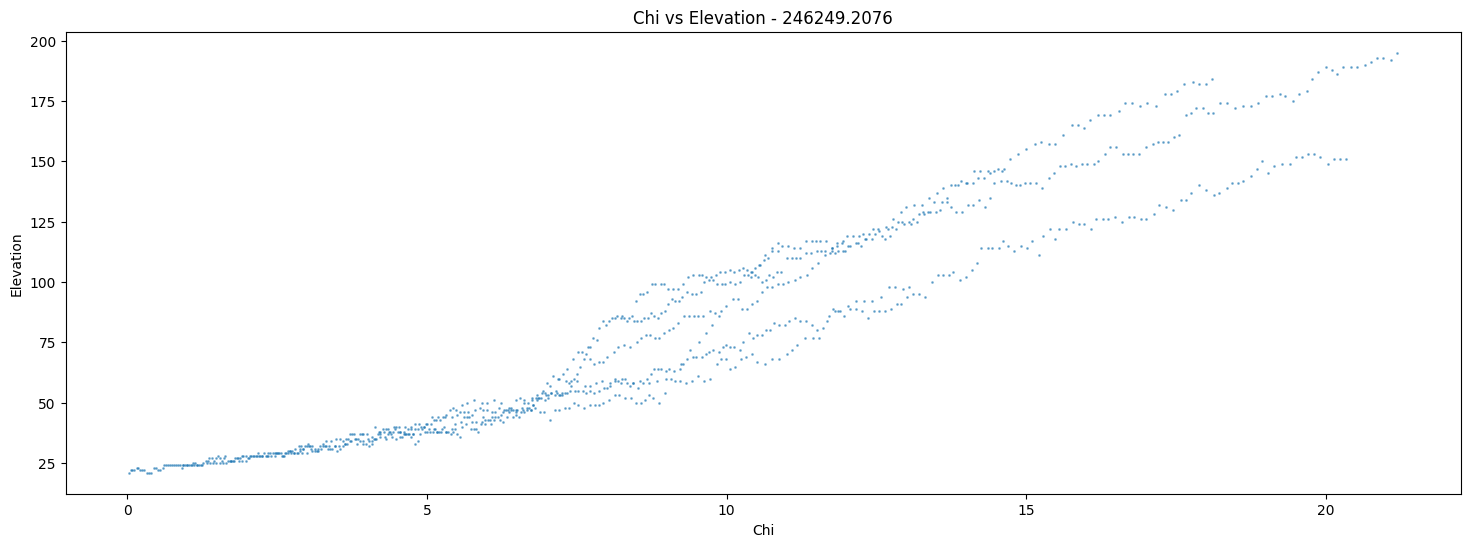

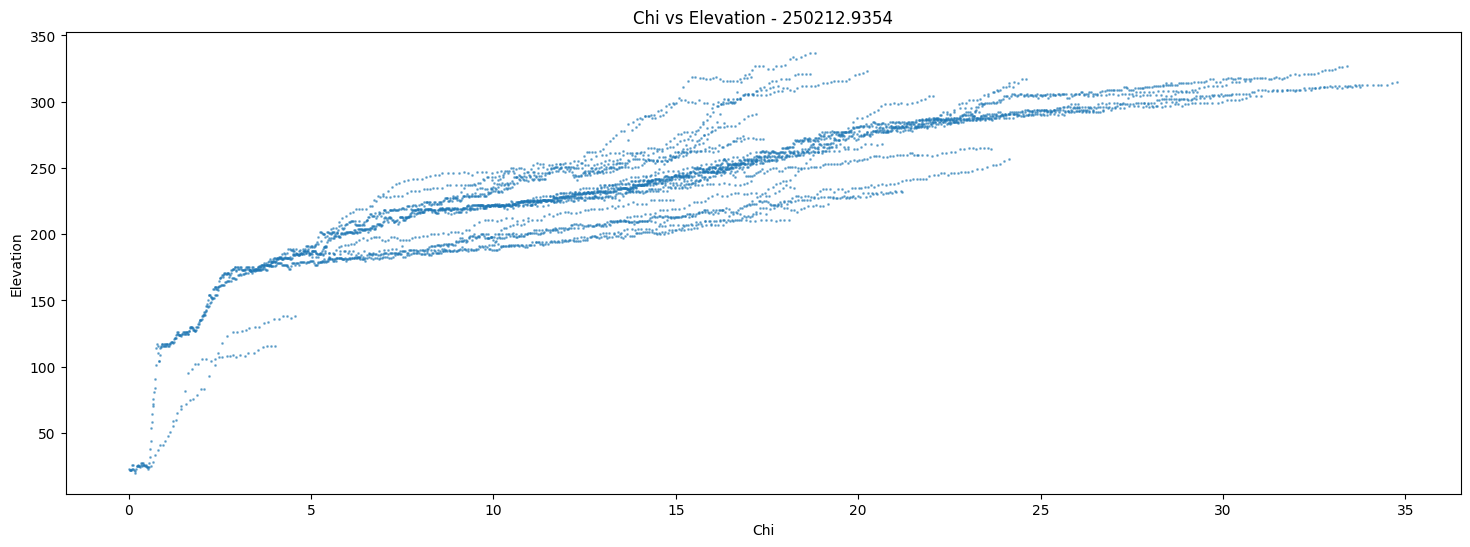

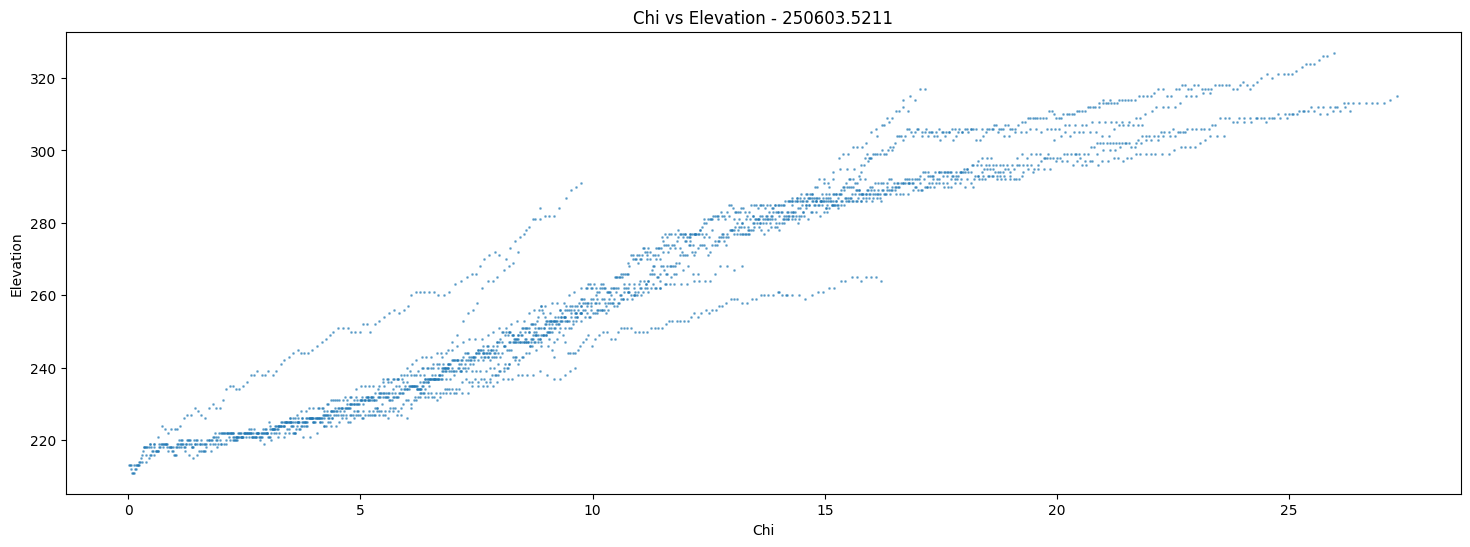

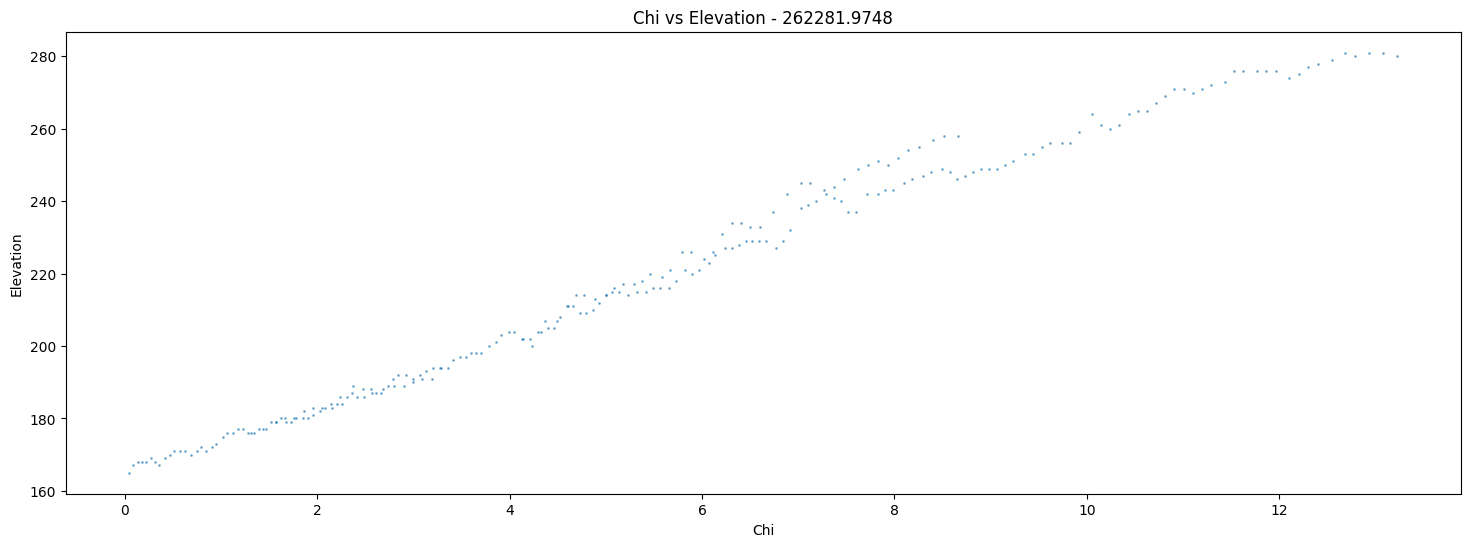

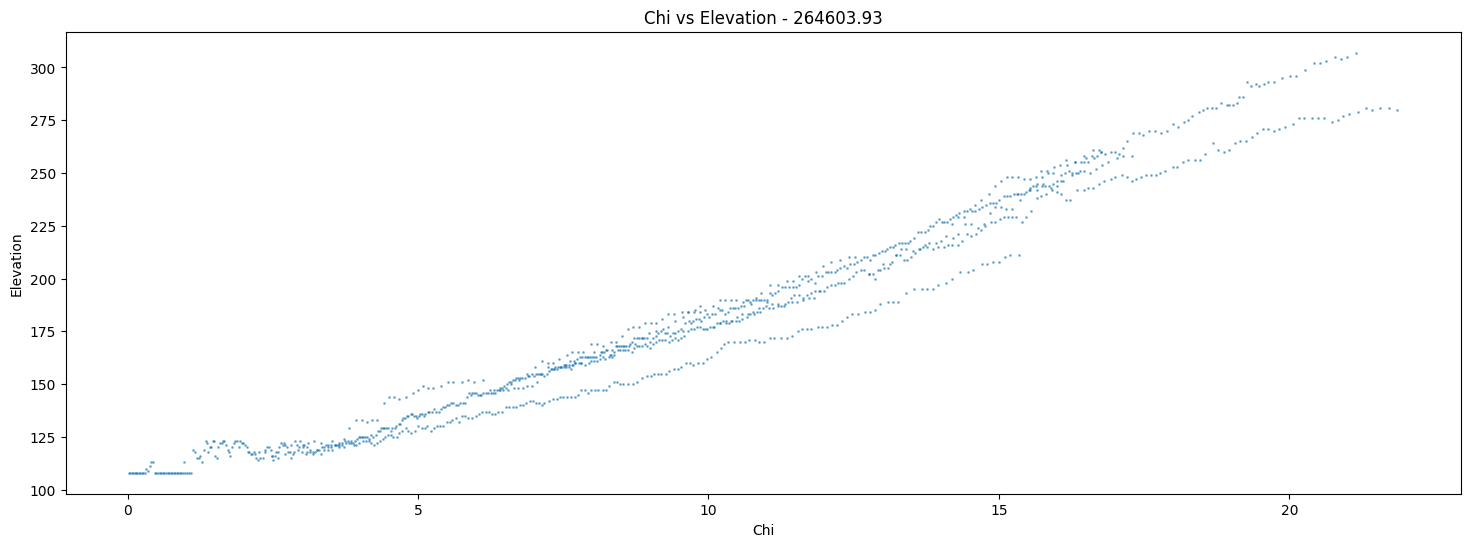

In [4]:
for outlet in outlets:
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6  # 1 km^2 in m^2
    
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_data[mask_out], elev_data[mask_out], s=1, alpha=0.5)
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    plt.title(f'Chi vs Elevation - {outlet[0]}')
    plt.show()


RP-S2:
  Chi: 8.75, Elevation: 99


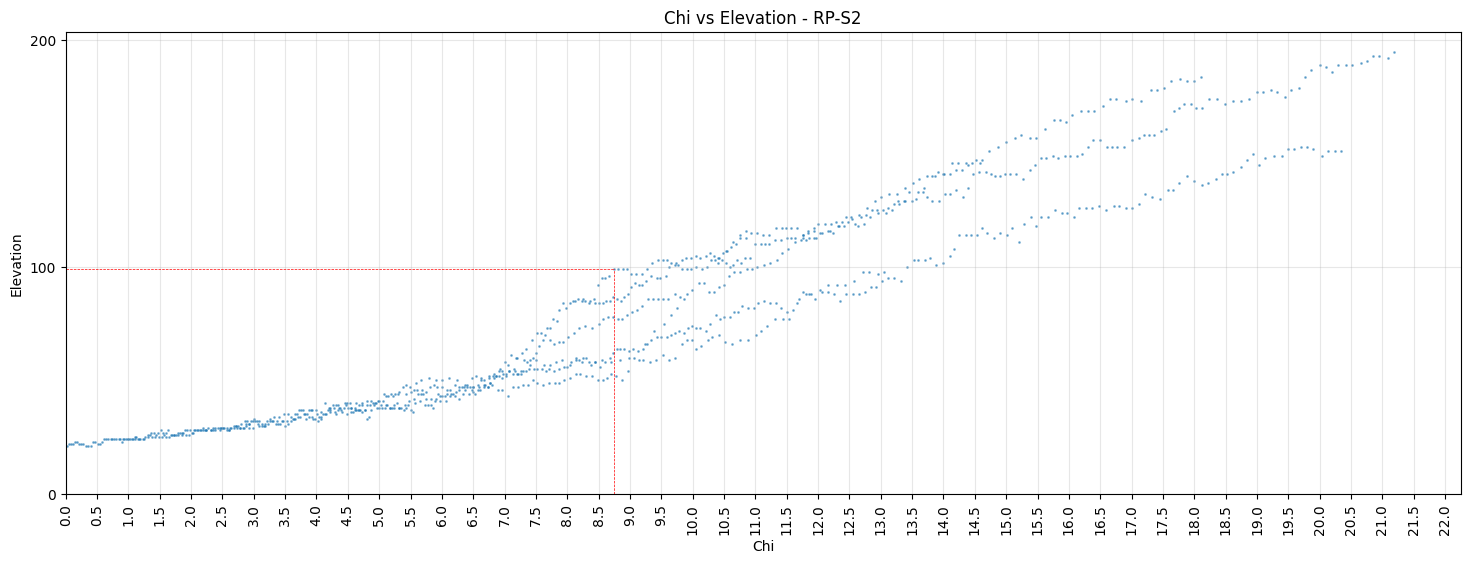


RP-S3:
  Chi: 0.78, Elevation: 117
  Chi: 2.90, Elevation: 175
  Chi: 8.50, Elevation: 245


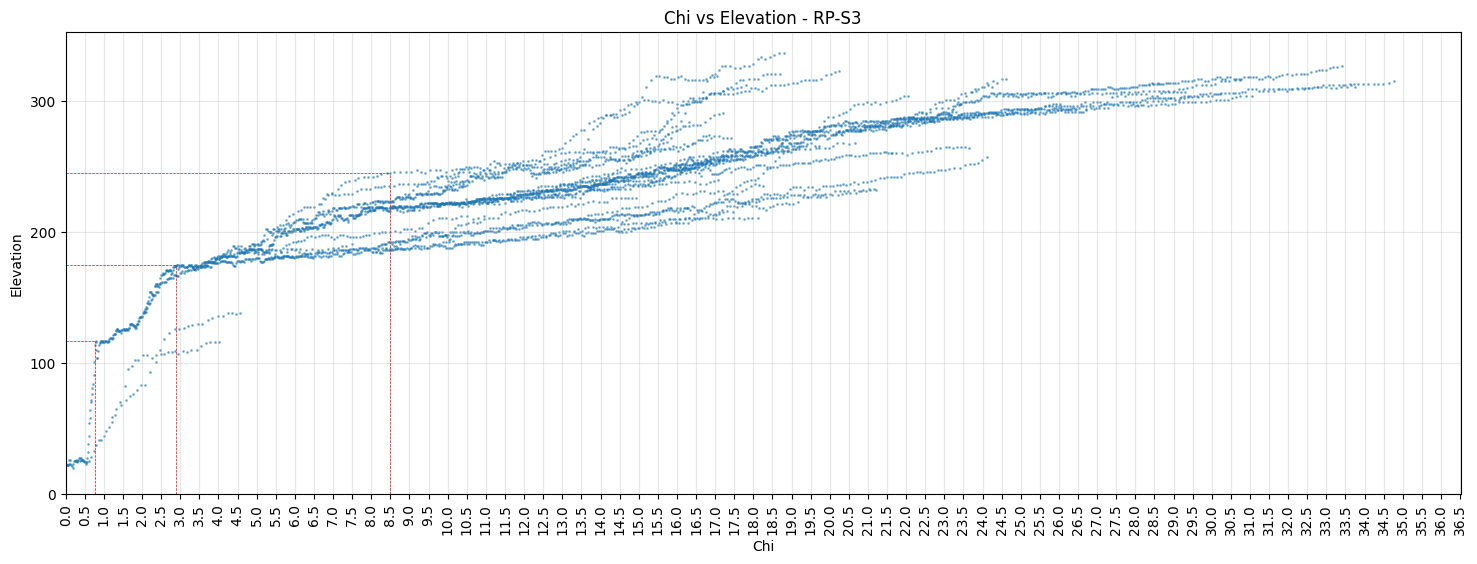

In [5]:
outlet_names = ['RP-S2', 'RP-S3']
outlets = [(246249.2076, 6240448.447),
           (250212.9354, 6237948.848)  # Use only these outlets
          ]
           
for i, outlet in enumerate(outlets):
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask_out = area_data >= 1e6
    chi_masked = chi_data[mask_out]
    elev_masked = elev_data[mask_out]
    
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_masked, elev_masked, s=1, alpha=0.5)
    plt.xlim(left=0)
    plt.ylim(bottom=0)
    
    plt.gca().xaxis.set_major_locator(plt.MultipleLocator(0.5))
    plt.gca().yaxis.set_major_locator(plt.MultipleLocator(100))
    
    plt.grid(True, alpha=0.3, which='major')
    plt.gca().tick_params(axis='x', rotation=90)
    
    # Knickpoint dictionary
    knickpoints_dict = {
        'RP-S2': [8.75],
        'RP-S3': [0.78, 2.9, 8.5],
    }
    
    outlet_name = outlet_names[i]
    knickpoints = knickpoints_dict.get(outlet_name, [])
    
    print(f"\n{outlet_name}:")
    for chi_val in knickpoints:
        idx = np.argmin(np.abs(chi_masked - chi_val))
        elev_val = elev_masked[idx]
        
        print(f"  Chi: {chi_val:.2f}, Elevation: {elev_val:.0f}")
        
        # Lines only to intersection point
        plt.plot([chi_val, chi_val], [0, elev_val], 'r--', linewidth=0.5)
        plt.plot([0, chi_val], [elev_val, elev_val], 'r--', linewidth=0.5)
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    plt.title(f'Chi vs Elevation - {outlet_name}')
    plt.show()

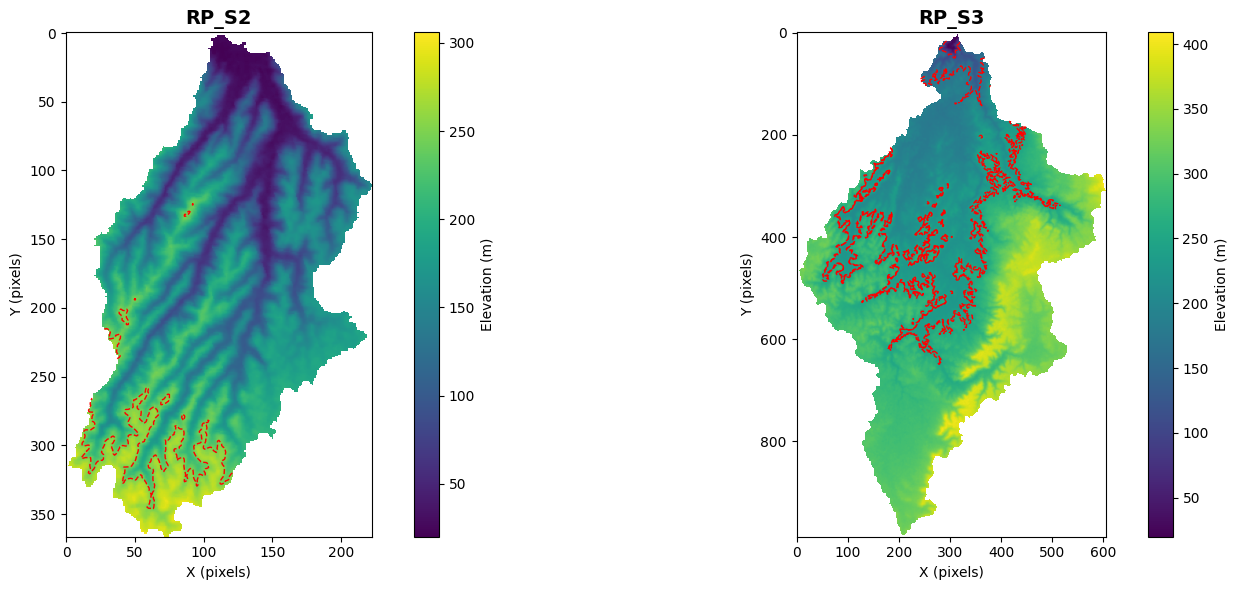

In [6]:
import rasterio
from rasterio.mask import mask as rasterio_mask
from rasterio.features import geometry_mask
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

dem_file = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
watersheds = [
    ('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp', 'RP_S2', 8.75),
    ('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp', 'RP_S3', [0.75, 2.75, 8.5, 15.5]),
]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (polygon_file, watershed_name, knickpoints) in enumerate(watersheds):
    ax = axes[idx]
    
    # Load polygon
    polygon = gpd.read_file(polygon_file)
    shapes = [geom for geom in polygon.geometry]
    
    # Load and mask DEM - use rasterio_mask instead of mask
    with rasterio.open(dem_file) as src:
        dem_data, dem_transform = rasterio_mask(src, shapes, crop=True)
        dem_data = dem_data[0].astype(float)
    
    # Set pixels outside polygon to NaN
    geom_mask_array = geometry_mask(shapes, out_shape=dem_data.shape, transform=dem_transform, invert=True)
    dem_data[~geom_mask_array] = np.nan
    
    # Convert knickpoints to list if single value
    if not isinstance(knickpoints, list):
        knickpoints = [knickpoints]
    
    # Plot DEM
    im = ax.imshow(dem_data, cmap='viridis')
    plt.colorbar(im, ax=ax, label='Elevation (m)')
    
    # Draw contour lines for each knickpoint elevation
    for knickpoint_chi in knickpoints:
        # Get elevation at this chi value
        idx_chi = np.argmin(np.abs(chi_masked - knickpoint_chi))
        knickpoint_elevation = elev_masked[idx_chi]
        
        # Draw contour line at that elevation
        ax.contour(dem_data, levels=[knickpoint_elevation], colors='red', linewidths=1, linestyles='--')
    
    ax.set_title(f'{watershed_name}', fontsize=14, fontweight='bold')
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')

plt.tight_layout()
plt.savefig('/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/BaseLevel/Figures/erosion_analysis_knickpoints.png', dpi=150, bbox_inches='tight')
plt.show()


RP_S3 - Monte Carlo Analysis (10,000 simulations)

Knickpoint elevation: 117m
----------------------------------------------------------------------
  Area above 117m: 208.87 km²
  Area below 117m: 0.96 km²
  Total area: 209.83 km²

  Input erosion rates:
    Upper: 30 ± 0.572 m/Myr
    Lower (measured): 34 ± 0.642 m/Myr

  Monte Carlo Results for Canyon (below knickpoint):
    Mean: 901.21 m/Myr
    Std Dev: 187.18 m/Myr
    1σ Range (68%): 712.88 to 1085.35 m/Myr (±186.24)
    2σ Range (95%): 529.84 to 1272.80 m/Myr (±371.48)
    Relative uncertainty: 20.8%
    Weighted average: 34.00 m/Myr

Knickpoint elevation: 175m
----------------------------------------------------------------------
  Area above 175m: 203.42 km²
  Area below 175m: 6.41 km²
  Total area: 209.83 km²

  Input erosion rates:
    Upper: 30 ± 0.572 m/Myr
    Lower (measured): 34 ± 0.642 m/Myr

  Monte Carlo Results for Canyon (below knickpoint):
    Mean: 161.06 m/Myr
    Std Dev: 27.99 m/Myr
    1σ Range (68%): 133.

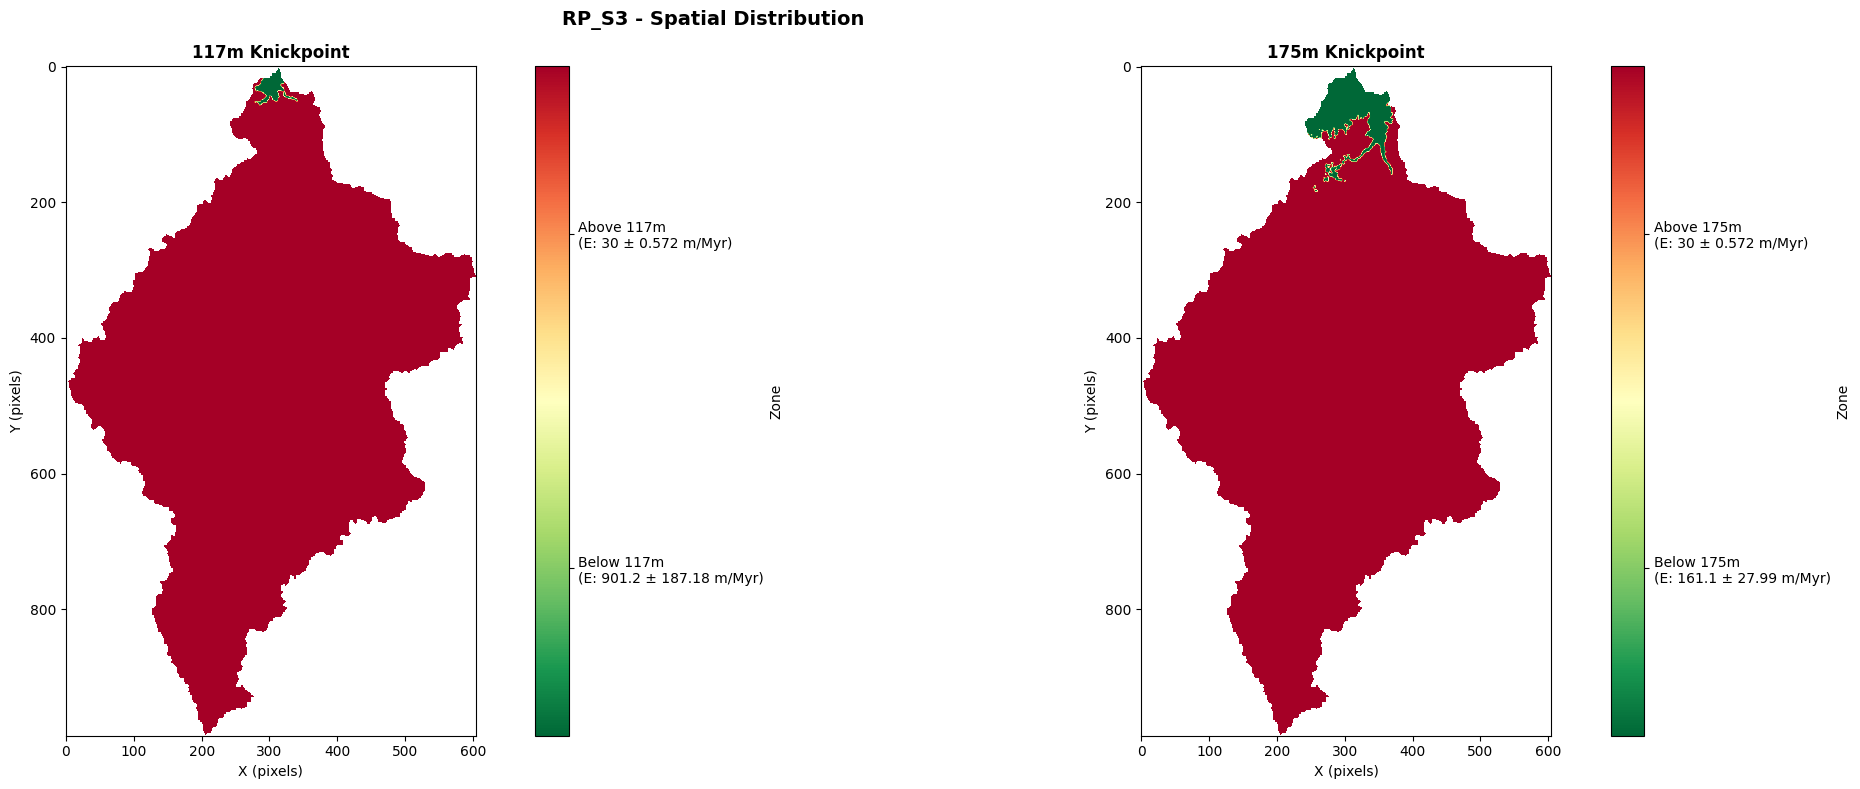

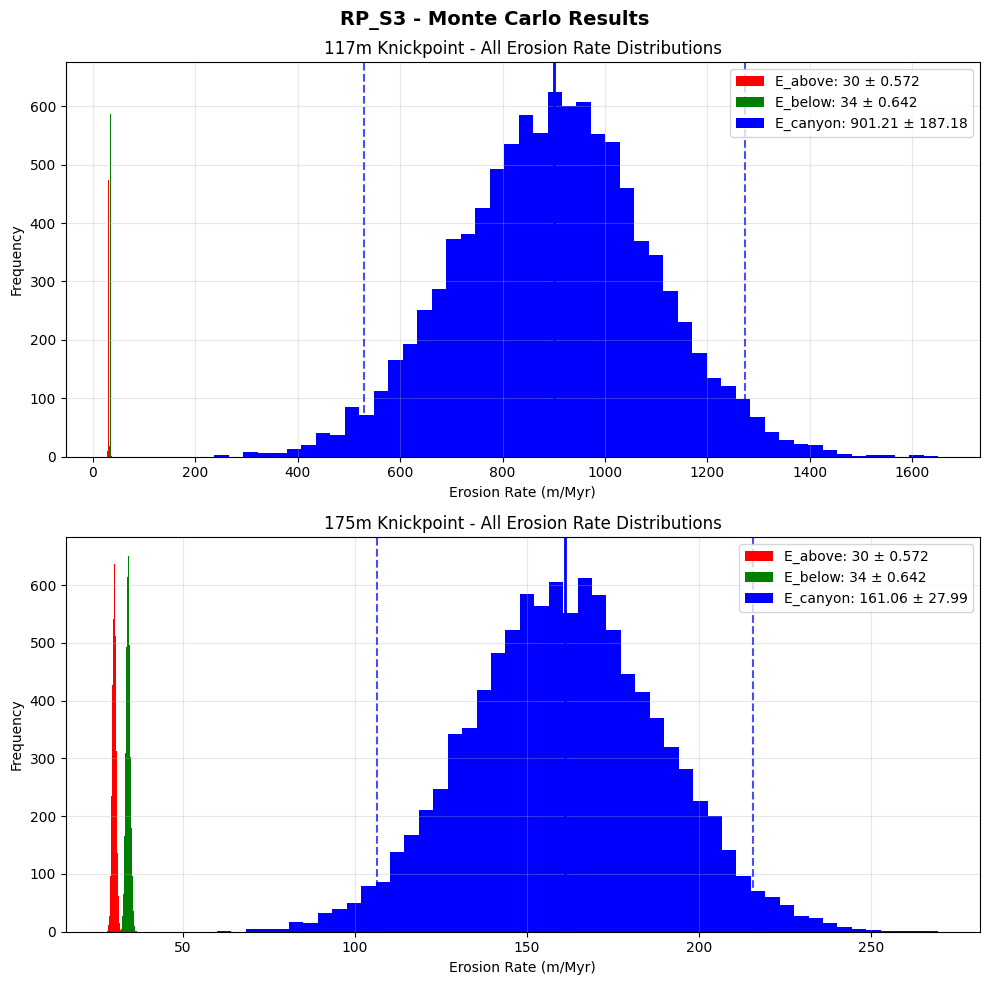

In [8]:
# Erosion rate analysis of canyon area below different knickpoint locations

# set random seed
np.random.seed(17) # random seed set to arbitrary number

def analyze_erosion_monte_carlo(dem_file, polygon_file, watershed_name, erosion_above=30, erosion_below=34, 
                                erosion_above_err=0.572, erosion_below_err=0.642, knickpoint_elevations=[117, 175],
                                num_simulations=10000):
    """
    Analyze area-weighted erosion rates using Monte Carlo simulation.
    
    Parameters:
    - dem_file: path to DEM raster file
    - polygon_file: path to watershed polygon shapefile
    - watershed_name: name for the watershed
    - erosion_above: erosion rate above knickpoint (m/Myr)
    - erosion_below: erosion rate below knickpoint (m/Myr)
    - erosion_above_err: uncertainty in erosion_above (1-sigma)
    - erosion_below_err: uncertainty in erosion_below (1-sigma)
    - knickpoint_elevations: list of elevation thresholds to analyze
    - num_simulations: number of Monte Carlo simulations (default 10000)
    """
    
    # Load polygon
    polygon = gpd.read_file(polygon_file)
    shapes = [geom for geom in polygon.geometry]
    
    # Load and mask DEM
    with rasterio.open(dem_file) as src:
        dem_data, dem_transform = mask(src, shapes, crop=True)
        dem_data = dem_data[0].astype(float)
    
    # Set pixels outside polygon to NaN
    geom_mask = geometry_mask(shapes, out_shape=dem_data.shape, transform=dem_transform, invert=True)
    dem_data[~geom_mask] = np.nan
    
    # Get cell size
    cell_size = dem_transform[0]
    cell_area = cell_size ** 2
    
    print(f"\n{'='*70}")
    print(f"{watershed_name} - Monte Carlo Analysis ({num_simulations:,} simulations)")
    print(f"{'='*70}")
    
    # Create figure for spatial plots
    fig_spatial, axes_spatial = plt.subplots(1, len(knickpoint_elevations), 
                                              figsize=(12 * len(knickpoint_elevations), 8))
    if len(knickpoint_elevations) == 1:
        axes_spatial = [axes_spatial]
    
    # Create figure for histograms
    fig_hist, axes_hist = plt.subplots(len(knickpoint_elevations), 1, 
                                        figsize=(10, 5 * len(knickpoint_elevations)))
    if len(knickpoint_elevations) == 1:
        axes_hist = [axes_hist]
    
    for idx, knickpoint_elevation in enumerate(knickpoint_elevations):
        ax_spatial = axes_spatial[idx]
        ax_hist = axes_hist[idx]
        
        # Create masks
        valid_mask = ~np.isnan(dem_data)
        above_mask = (dem_data > knickpoint_elevation) & valid_mask
        below_mask = (dem_data <= knickpoint_elevation) & valid_mask
        
        # Calculate areas (treated as exact)
        area_above = np.sum(above_mask) * cell_area
        area_below = np.sum(below_mask) * cell_area
        total_area = area_above + area_below
        
        if area_below == 0:
            print(f"\nKnickpoint elevation: {knickpoint_elevation}m - SKIPPED (no area below knickpoint)")
            continue
        
        # Monte Carlo simulation
        # Generate random samples for erosion rates
        erosion_above_samples = np.random.normal(erosion_above, erosion_above_err, num_simulations)
        erosion_below_samples = np.random.normal(erosion_below, erosion_below_err, num_simulations)
        
        # Calculate E_lower for each simulation
        erosion_lower_samples = (erosion_below_samples * total_area - erosion_above_samples * area_above) / area_below
        
        # Calculate statistics from Monte Carlo samples
        erosion_lower_mean = np.mean(erosion_lower_samples)
        erosion_lower_median = np.median(erosion_lower_samples)
        erosion_lower_std = np.std(erosion_lower_samples)
        
        # Calculate confidence intervals
        p2_5 = np.percentile(erosion_lower_samples, 2.5)    # Lower 2σ
        p16 = np.percentile(erosion_lower_samples, 16)      # Lower 1σ
        p84 = np.percentile(erosion_lower_samples, 84)      # Upper 1σ
        p97_5 = np.percentile(erosion_lower_samples, 97.5)  # Upper 2σ
        
        # Calculate weighted average
        weighted_erosion = (erosion_above * area_above + erosion_lower_mean * area_below) / total_area
        
        # Calculate relative uncertainty
        rel_uncertainty = (erosion_lower_std / erosion_lower_mean) * 100 if erosion_lower_mean != 0 else 0
        
        # Create spatial visualization
        colored_dem = np.full_like(dem_data, np.nan, dtype=float)
        colored_dem[above_mask] = 1
        colored_dem[below_mask] = 0
        
        im = ax_spatial.imshow(colored_dem, cmap='RdYlGn_r', vmin=0, vmax=1)
        cbar = plt.colorbar(im, ax=ax_spatial, label='Zone')
        cbar.set_ticks([0.25, 0.75])
        cbar.set_ticklabels([f'Below {knickpoint_elevation}m\n(E: {erosion_lower_mean:.1f} ± {erosion_lower_std:.2f} m/Myr)', 
                              f'Above {knickpoint_elevation}m\n(E: {erosion_above} ± {erosion_above_err} m/Myr)'])
        
        ax_spatial.set_title(f'{knickpoint_elevation}m Knickpoint', fontsize=12, fontweight='bold')
        ax_spatial.set_xlabel('X (pixels)')
        ax_spatial.set_ylabel('Y (pixels)')
        
        # Create combined histogram showing all three distributions
        ax_hist.hist(erosion_above_samples, bins=50, alpha=1, color='red', label=f'E_above: {erosion_above} ± {erosion_above_err}')
        ax_hist.hist(erosion_below_samples, bins=50, alpha=1, color='green', label=f'E_below: {erosion_below} ± {erosion_below_err}')
        ax_hist.hist(erosion_lower_samples, bins=50, alpha=1, color='blue', label=f'E_canyon: {erosion_lower_mean:.2f} ± {erosion_lower_std:.2f}')
        
        # Add vertical lines for E_canyon confidence intervals
        ax_hist.axvline(erosion_lower_mean, color='blue', linestyle='-', linewidth=2)
        ax_hist.axvline(p2_5, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
        ax_hist.axvline(p97_5, color='blue', linestyle='--', linewidth=1.5, alpha=0.7)
        
        ax_hist.set_xlabel('Erosion Rate (m/Myr)')
        ax_hist.set_ylabel('Frequency')
        ax_hist.set_title(f'{knickpoint_elevation}m Knickpoint - All Erosion Rate Distributions')
        ax_hist.legend(loc='upper right')
        ax_hist.grid(True, alpha=0.3)
        
        # Print results
        print(f"\nKnickpoint elevation: {knickpoint_elevation}m")
        print("-" * 70)
        print(f"  Area above {knickpoint_elevation}m: {area_above/1e6:,.2f} km²")
        print(f"  Area below {knickpoint_elevation}m: {area_below/1e6:,.2f} km²")
        print(f"  Total area: {total_area/1e6:,.2f} km²")
        
        print(f"\n  Input erosion rates:")
        print(f"    Upper: {erosion_above} ± {erosion_above_err} m/Myr")
        print(f"    Lower (measured): {erosion_below} ± {erosion_below_err} m/Myr")
        print(f"\n  Monte Carlo Results for Canyon (below knickpoint):")
        print(f"    Mean: {erosion_lower_mean:.2f} m/Myr")
        print(f"    Std Dev: {erosion_lower_std:.2f} m/Myr")
        print(f"    1σ Range (68%): {p16:.2f} to {p84:.2f} m/Myr (±{(p84-p16)/2:.2f})")
        print(f"    2σ Range (95%): {p2_5:.2f} to {p97_5:.2f} m/Myr (±{(p97_5-p2_5)/2:.2f})")
        print(f"    Relative uncertainty: {rel_uncertainty:.1f}%")
        print(f"    Weighted average: {weighted_erosion:.2f} m/Myr")
    
    fig_spatial.suptitle(f'{watershed_name} - Spatial Distribution', fontsize=14, fontweight='bold')
    fig_spatial.tight_layout()
    fig_spatial.savefig(f'/Users/Glong1/Desktop/erosion_analysis_{watershed_name}_spatial.png', dpi=150, bbox_inches='tight')
    
    fig_hist.suptitle(f'{watershed_name} - Monte Carlo Results', fontsize=14, fontweight='bold')
    fig_hist.tight_layout()
    fig_hist.savefig(f'/Users/Glong1/Desktop/erosion_analysis_{watershed_name}_histogram.png', dpi=150, bbox_inches='tight')
    
    plt.show()

# Use the function
dem_file = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
watersheds = [
    ('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp', 'RP_S3'),
]

for polygon_file, name in watersheds:
    analyze_erosion_monte_carlo(dem_file, polygon_file, name, 
                                erosion_above=30, erosion_below=34, 
                                erosion_above_err=0.572, erosion_below_err=0.642, 
                                knickpoint_elevations=[117, 175],
                                num_simulations=10000)

In [8]:
import pandas as pd

outlets = [
    (246249.2076, 6240448.447),
    (250212.9354, 6237948.848),
    (250603.5211, 6228481.157),
    (262281.9748, 6217862.614),
    (264603.93, 6224733.92)
]

def export_outlet_data(outlet_index, filename=None):
    """
    Export chi and elevation data for an outlet to CSV.
    
    outlet_index: which outlet to export (0-4)
    filename: name of CSV file (default: outlet_0.csv, outlet_1.csv, etc.)
    """
    if filename is None:
        filename = f'outlet_{outlet_index}.csv'
    
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Create dataframe and save
    df = pd.DataFrame({
        'Chi': chi_filtered,
        'Elevation': elev_filtered
    })
    
    df.to_csv(filename, index=False)
    print(f"Saved {filename} with {len(df)} data points")
    return df

# export files
for i in range(4):
    export_outlet_data(i, f'/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_{i}.csv')

Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_0.csv with 980 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_1.csv with 4986 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_2.csv with 2521 data points
Saved /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/Baselevel/chi_elevation_points/outlet_3.csv with 233 data points


# ksn (steepness) idenification through linear regression of chi-elevation plots

In [9]:
def analyze_outlet(outlet_index, knickpoints):
    """
    Calculate and plot ksn for different segments of a single outlet.
    
    outlet_index: which outlet to analyze (0-4)
    knickpoints: list of (chi, elevation) tuples marking segment boundaries
    """
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Plot all data
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_filtered, elev_filtered, s=1, alpha=0.5, label='Data', color='gray')
    
    # Plot knickpoints
    knickpoint_chis = [k[0] for k in knickpoints]
    knickpoint_elevs = [k[1] for k in knickpoints]
    plt.scatter(knickpoint_chis, knickpoint_elevs, color='black', s=100, marker='.', linewidth=1, label='Knickpoints')
    
    ksn_list = []
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Create segments from knickpoints
    for seg_idx in range(len(knickpoints) - 1):
        chi_min = knickpoints[seg_idx][0]
        chi_max = knickpoints[seg_idx + 1][0]
        
        segment_mask = (chi_filtered >= chi_min) & (chi_filtered <= chi_max)
        chi_seg = chi_filtered[segment_mask]
        elev_seg = elev_filtered[segment_mask]
        
        if len(chi_seg) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(chi_seg, elev_seg)
            ksn_list.append(slope)
            
            # Plot the fitted line for this segment
            x_line = np.array([chi_seg.min(), chi_seg.max()])
            y_line = slope * x_line + intercept
            plt.plot(x_line, y_line, linewidth=2.5, color=colors[seg_idx], 
                    label=f'Segment {seg_idx+1}: ksn = {slope:.2f} (R² = {r_value**2:.3f})')
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    plt.title(f'Chi vs Elevation - Outlet {outlet_index}')
    plt.legend()
    plt.show()
    
    print(f"Outlet {outlet_index}: ksn values = {[f'{k:.2f}' for k in ksn_list]}")
    return ksn_list

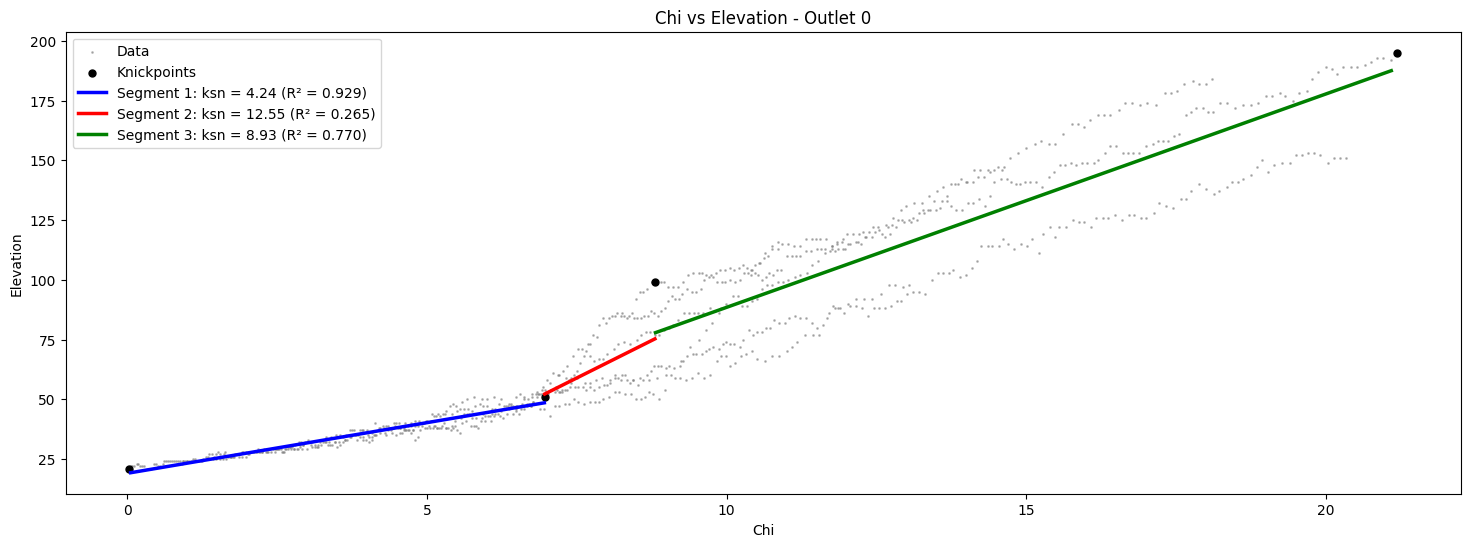

Outlet 0: ksn values = ['4.24', '12.55', '8.93']


[4.23736959189485, 12.547448575438978, 8.92704741013345]

In [10]:
# Enter knickpoint (chi, elevation) locations both the bottom and top locations:
# RP-S2
analyze_outlet(0, [(0.026572082, 21), (6.96, 51), (8.81, 99), (21.1904427, 195)])

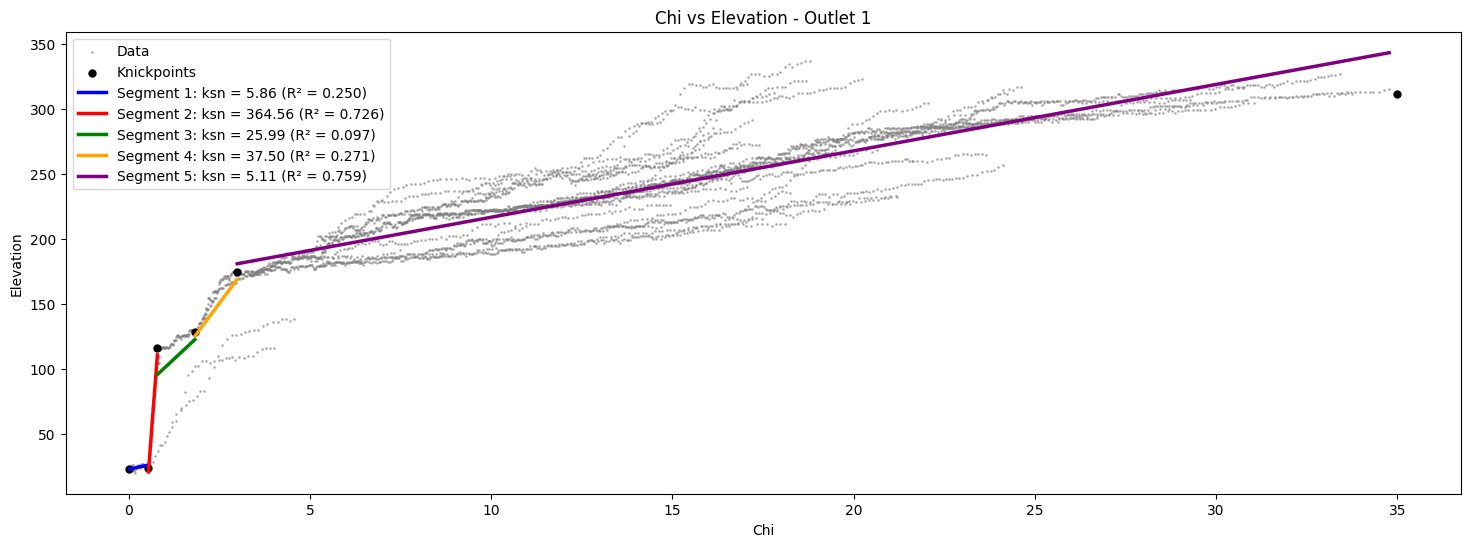

Outlet 1: ksn values = ['5.86', '364.56', '25.99', '37.50', '5.11']


[5.864638619390934,
 364.5647448323169,
 25.98714700138822,
 37.49838582403038,
 5.107038106606756]

In [11]:
# RP-S3
analyze_outlet(1, [(0.012829789, 23), (0.547, 24), (0.796, 116), (1.84, 128), (2.997, 174), (35, 311)])

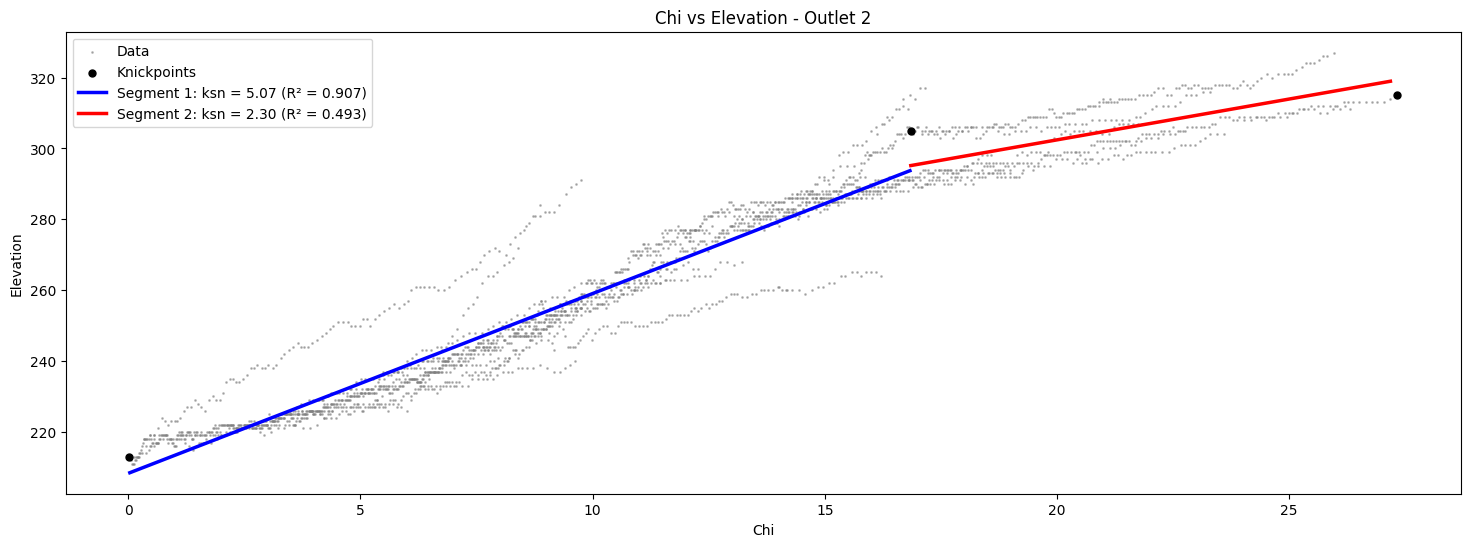

Outlet 2: ksn values = ['5.07', '2.30']


[5.072765847210626, 2.303693760438962]

In [12]:
# RP-S3u
analyze_outlet(2, [(0.016482489, 213), (16.85, 305), (27.32708722,315)])

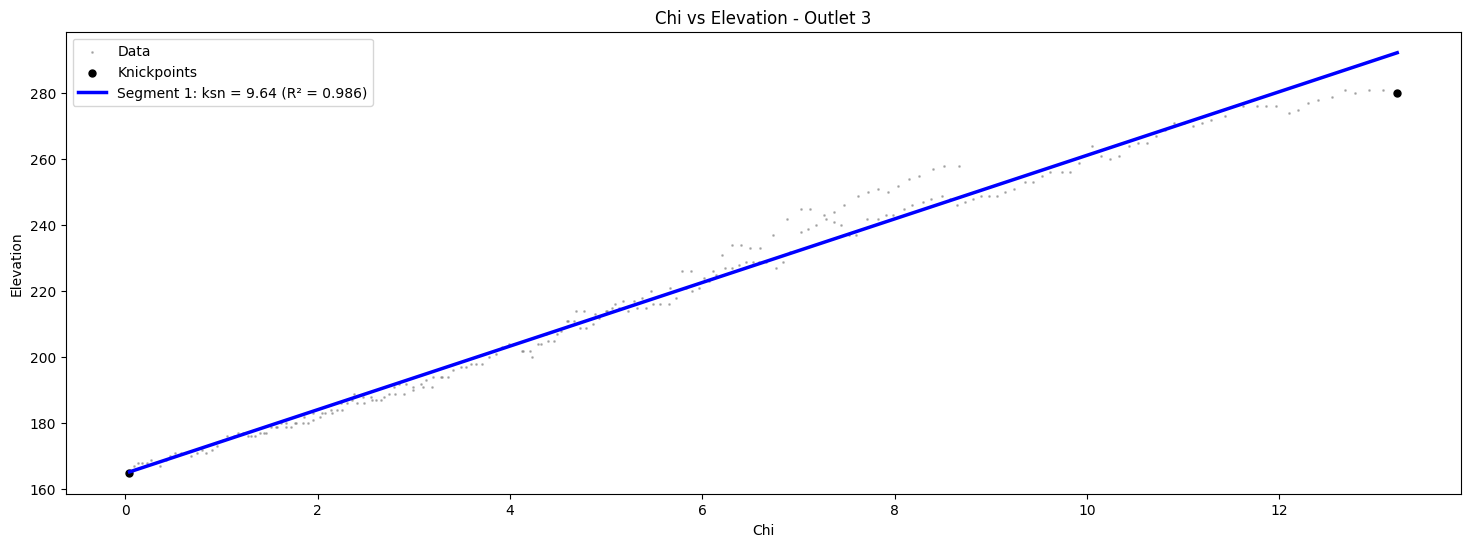

Outlet 3: ksn values = ['9.64']


[9.635589051335689]

In [13]:
# RP-S4u
analyze_outlet(3, [(0.04, 165), (13.23, 280)])

In [14]:
# Getting ksn from slope of smoothed lines. 

def analyze_outlet_smoothed(outlet_index, knickpoints, smooth=True, window=51):
    """
    Calculate and plot ksn for different segments of a single outlet with optional smoothing.
    
    outlet_index: which outlet to analyze (0-4)
    knickpoints: list of (chi, elevation) tuples marking segment boundaries
    smooth: whether to smooth the data (default True)
    window: smoothing window size (must be odd number, default 51)
    """
    outlet = outlets[outlet_index]
    
    # Calculate chi and elevation data
    chi_single = d.Chi(flow_direction = fd, area = area, theta = 0.4, Ao = 1, outlets = [outlet])
    
    chi_data = chi_single._griddata[chi_single._griddata > 0]
    elev_data = elevation._griddata[chi_single._griddata > 0]
    area_data = area._griddata[chi_single._griddata > 0]
    
    # Mask out areas less than 1 km^2
    mask = area_data >= 1e6
    
    chi_filtered = chi_data[mask]
    elev_filtered = elev_data[mask]
    
    # Sort by chi
    sort_idx = np.argsort(chi_filtered)
    chi_sorted = chi_filtered[sort_idx]
    elev_sorted = elev_filtered[sort_idx]
    
    # Apply smoothing if requested
    if smooth:
        window = min(window, len(elev_sorted) // 2 * 2 + 1)  # Ensure window isn't larger than data
        smoothed_elev = savgol_filter(elev_sorted, window, 3)
    else:
        smoothed_elev = elev_sorted
    
    # Plot all data
    plt.figure(figsize=(18, 6))
    plt.scatter(chi_sorted, elev_sorted, s=1, alpha=0.3, color='lightgray', label='Raw data')
    
    if smooth:
        plt.plot(chi_sorted, smoothed_elev, 'gray', linewidth=1.5, alpha=0.7, label='Smoothed')
    
    # Plot knickpoints
    knickpoint_chis = [k[0] for k in knickpoints]
    knickpoint_elevs = [k[1] for k in knickpoints]
    plt.scatter(knickpoint_chis, knickpoint_elevs, color='black', s=20, marker='.', linewidth=3, label='Knickpoints')
    
    ksn_list = []
    colors = ['blue', 'red', 'green', 'orange', 'purple']
    
    # Create segments from knickpoints
    for seg_idx in range(len(knickpoints) - 1):
        chi_min = knickpoints[seg_idx][0]
        chi_max = knickpoints[seg_idx + 1][0]
        
        segment_mask = (chi_sorted >= chi_min) & (chi_sorted <= chi_max)
        chi_seg = chi_sorted[segment_mask]
        elev_seg = smoothed_elev[segment_mask] if smooth else elev_sorted[segment_mask]
        
        if len(chi_seg) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(chi_seg, elev_seg)
            ksn_list.append(slope)
            
            # Plot the fitted line for this segment
            x_line = np.array([chi_seg.min(), chi_seg.max()])
            y_line = slope * x_line + intercept
            plt.plot(x_line, y_line, linewidth=1, color=colors[seg_idx], 
                    label=f'Segment {seg_idx+1}: ksn = {slope:.2f} (R² = {r_value**2:.3f})')
    
    plt.xlabel('Chi')
    plt.ylabel('Elevation')
    title = f'Chi vs Elevation - Outlet {outlet_index}'
    if smooth:
        title += ' (Smoothed)'
    plt.title(title)
    plt.legend()
    plt.show()
    
    print(f"Outlet {outlet_index}: ksn values = {[f'{k:.2f}' for k in ksn_list]}")
    return ksn_list

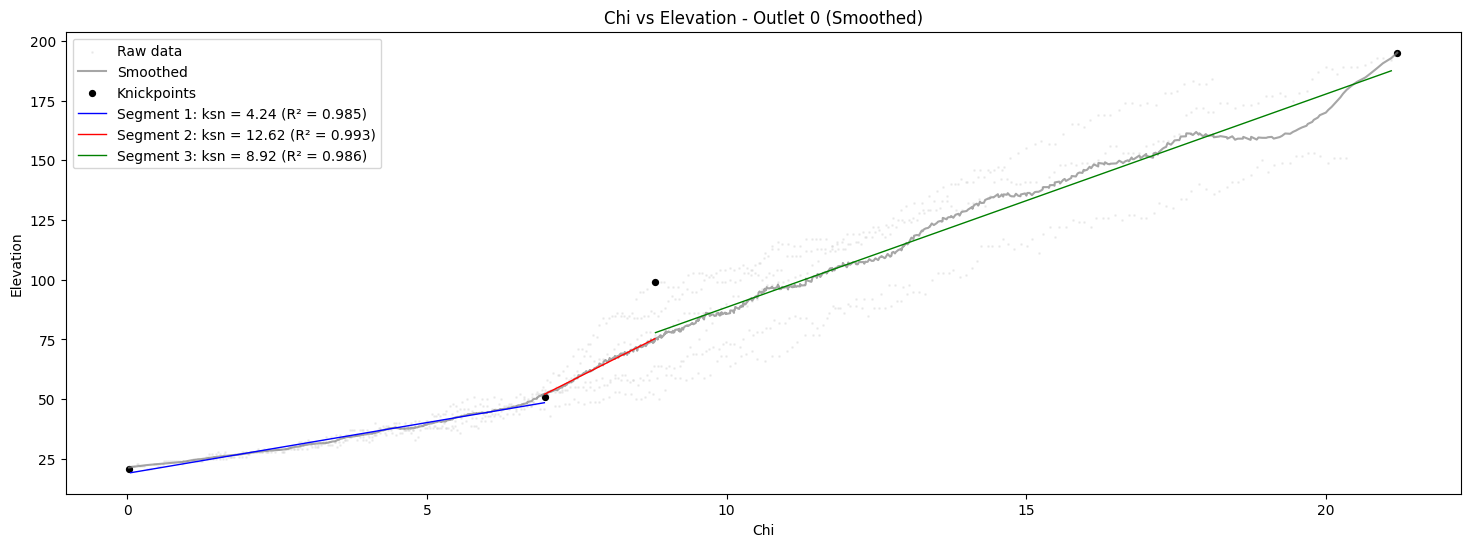

Outlet 0: ksn values = ['4.24', '12.62', '8.92']


[4.2434931725283205, 12.615938281342771, 8.923878881201093]

In [15]:
# RP-S2
analyze_outlet_smoothed(0, [(0.026572082, 21), (6.96, 51), (8.81, 99), (21.1904427, 195)], smooth=True, window=51)

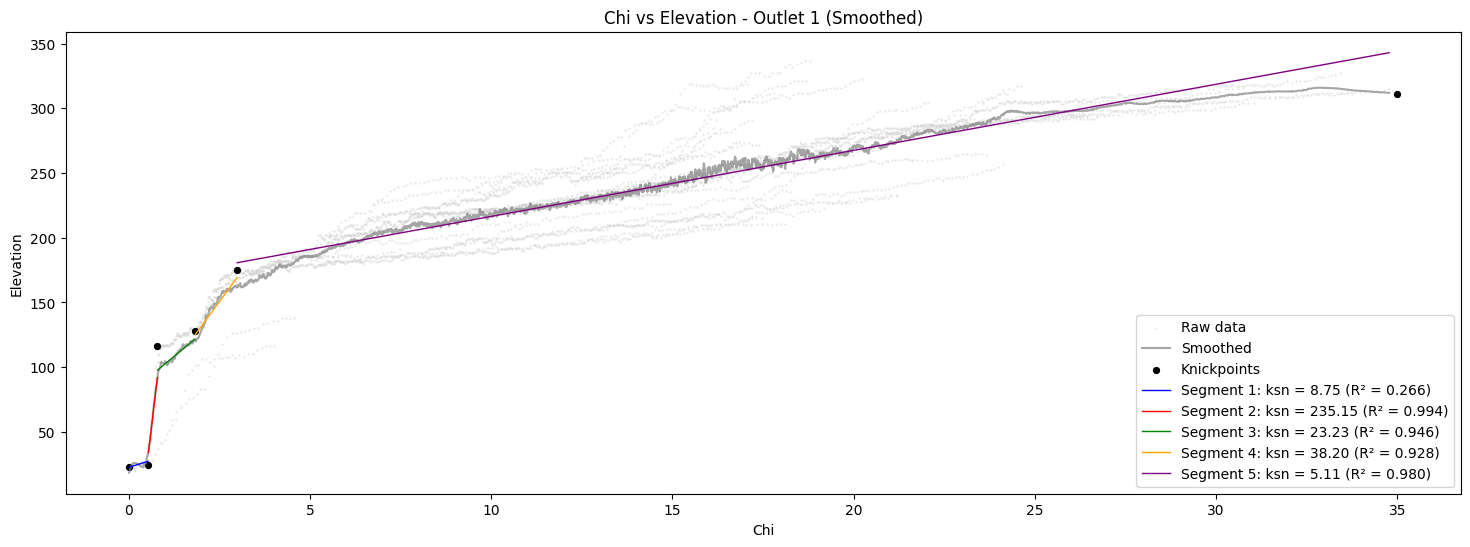

Outlet 1: ksn values = ['8.75', '235.15', '23.23', '38.20', '5.11']


[8.75072323881374,
 235.15211349704117,
 23.228909177420547,
 38.200613579243004,
 5.108126417976834]

In [16]:
# Rapel River outlets - modify knickpoints and run individual analyses
# RP-S3
analyze_outlet_smoothed(1, [(0.012829789, 23), (0.547, 24), (0.796, 116), (1.84, 128), (2.997, 175), (35, 311)], smooth=True, window=51)

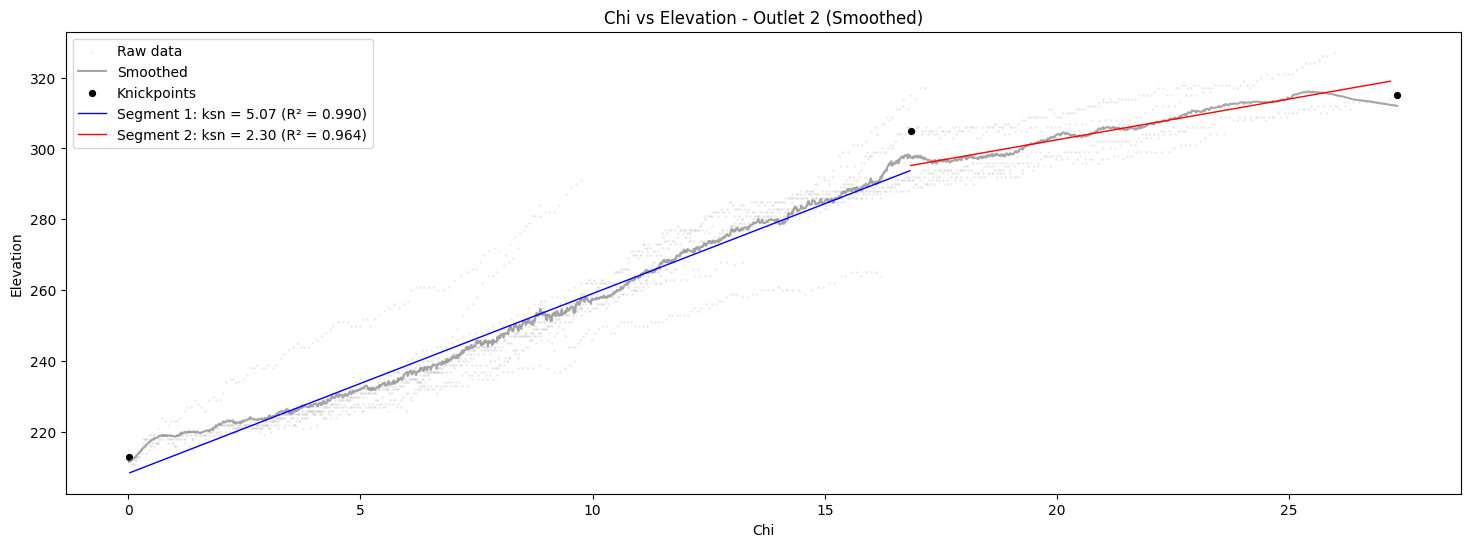

Outlet 2: ksn values = ['5.07', '2.30']


[5.0715740229507835, 2.3028767507250274]

In [17]:
# RP-S3u
analyze_outlet_smoothed(2, [(0.016482489, 213), (16.85, 305), (27.32708722,315)], smooth=True, window=51)

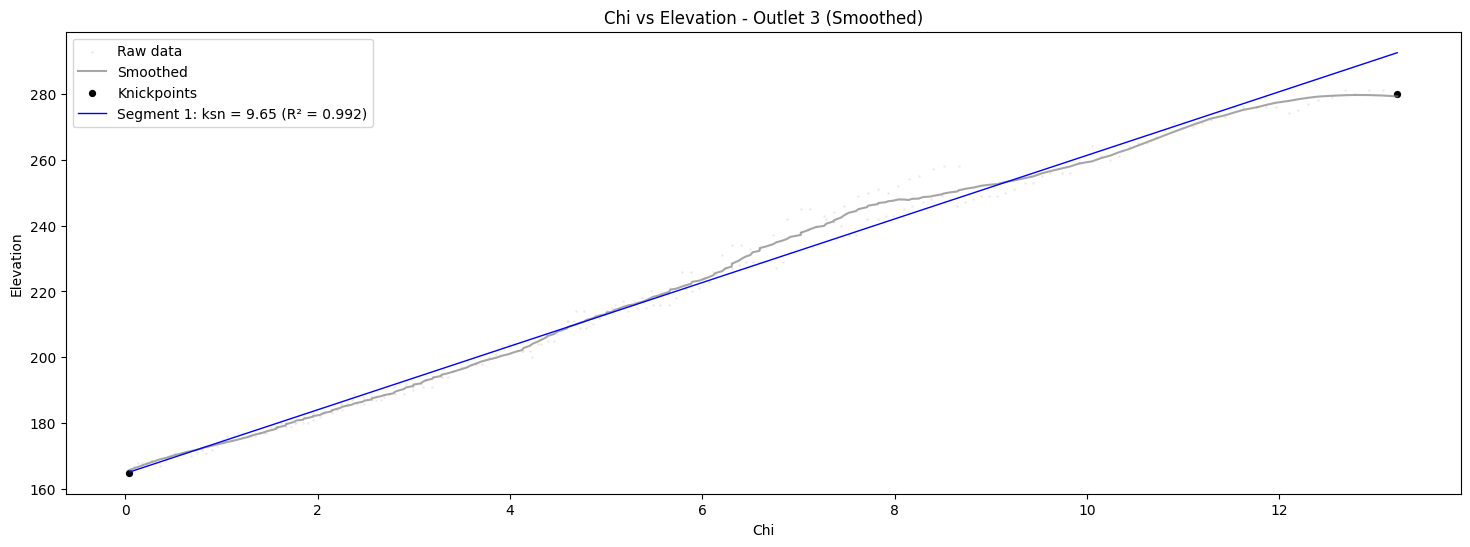

Outlet 3: ksn values = ['9.65']


[9.648144540379505]

In [18]:
# RP-S4u
analyze_outlet_smoothed(3, [(0.04, 165), (13.23, 280)], smooth=True, window=51)

In [19]:
# Read shapefiles
shp1 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp')
shp2 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp')
shp3 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3u_mask/RP_S3u_mask.shp')
shp4 = gpd.read_file('/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S4u_mask/RP_S4u_mask.shp')

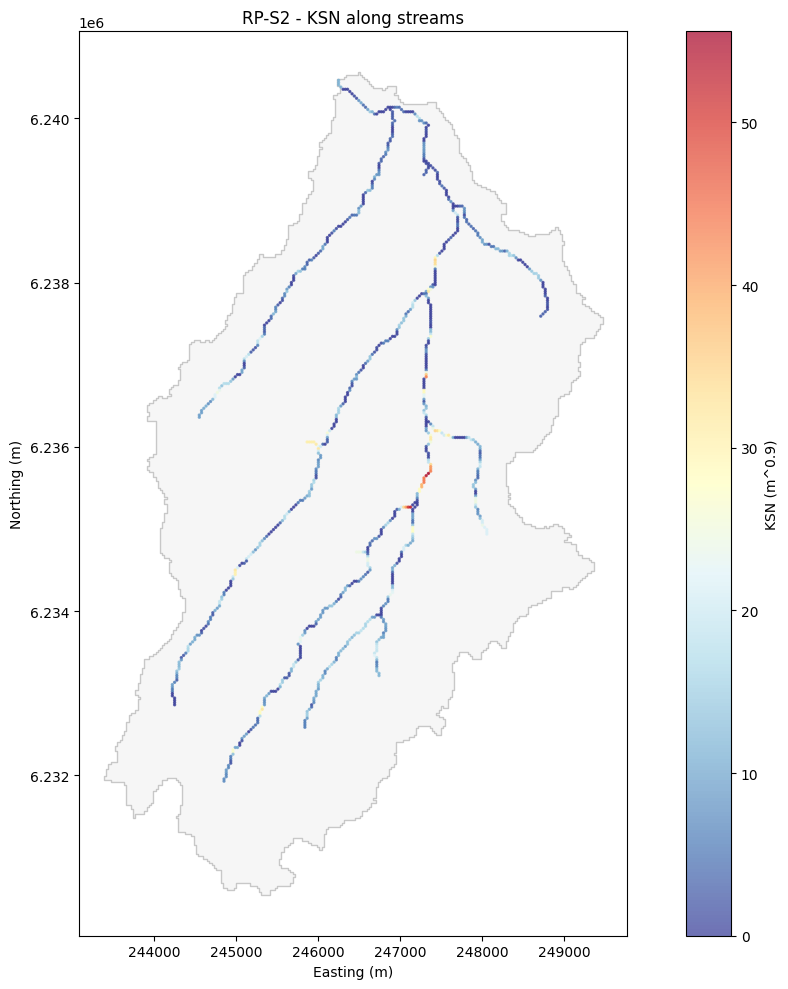

Plotted RP-S2 with 980 stream points


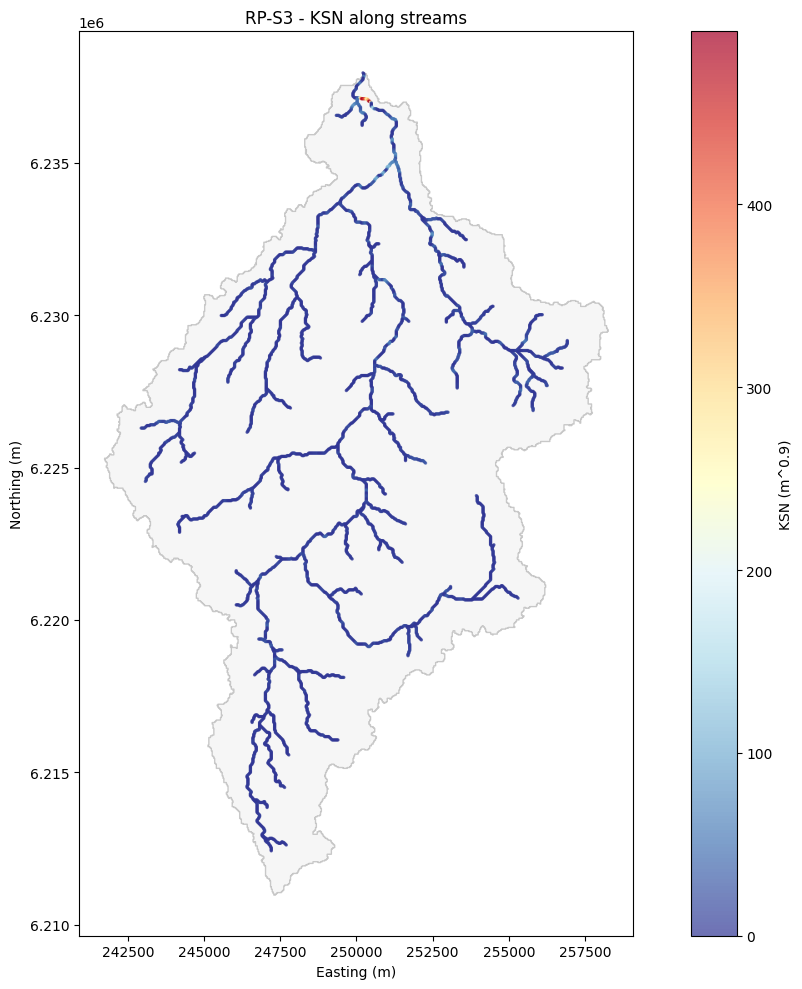

Plotted RP-S3 with 4986 stream points


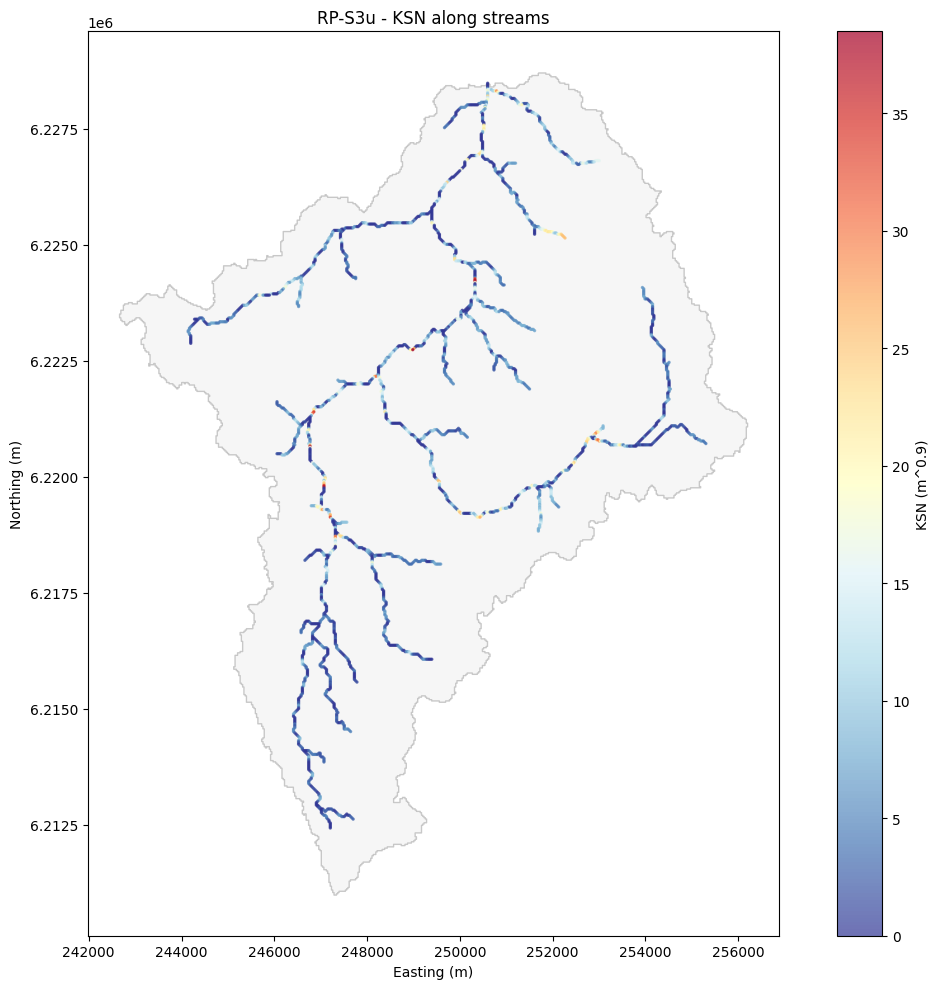

Plotted RP-S3u with 2521 stream points


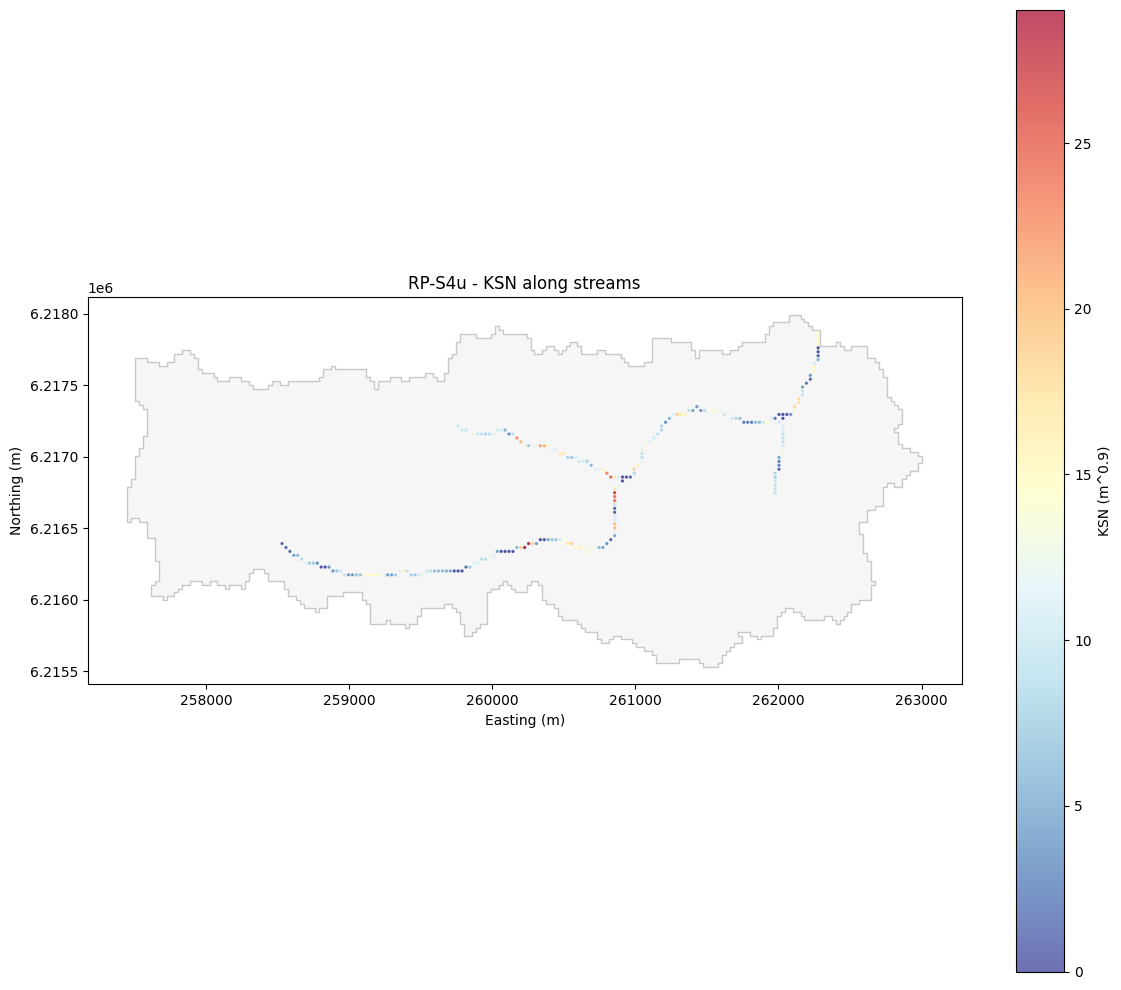

Plotted RP-S4u with 233 stream points


In [20]:
# Plotting chi for each polygon

# Define chi ranges and ksn values for each outlet
outlet_segments = {
    0: {  # RP-S2
        'chi_ranges': [(0, 0.026572082), (0.026572082, 6.96), (6.96, 8.81), (8.81, 21.1904427)],
        'ksn_values': [4.24, 12.62, 8.92, 1.0],
        'shp': shp1,
        'name': 'RP-S2'
    },
    1: {  # RP-S3
        'chi_ranges': [(0, 0.012829789), (0.012829789, 0.547), (0.547, 0.796), (0.796, 1.84), (1.84, 2.997), (2.997, 35)],
        'ksn_values': [8.75, 235.15, 23.23, 38.20, 5.11, 1.0],
        'shp': shp2,
        'name': 'RP-S3'
    },
    2: {  # RP-S3u
        'chi_ranges': [(0, 0.016482489), (0.016482489, 16.85), (16.85, 27.32708722)],
        'ksn_values': [5.07, 2.30, 1.0],
        'shp': shp3,
        'name': 'RP-S3u'
    },
    3: {  # RP-S4u
        'chi_ranges': [(0, 0.04), (0.04, 13.23)],
        'ksn_values': [9.65, 1.0],
        'shp': shp4,
        'name': 'RP-S4u'
    }
}

def assign_ksn_to_chi(chi_value, outlet_idx):
    """Assign ksn value based on chi value"""
    segments = outlet_segments[outlet_idx]
    for chi_range, ksn in zip(segments['chi_ranges'], segments['ksn_values']):
        if chi_range[0] <= chi_value < chi_range[1]:
            return ksn
    return segments['ksn_values'][-1]

def plot_outlet_streams(outlet_idx):
    """Plot streams colored by ksn within polygon"""
    outlet = outlets[outlet_idx]
    segments = outlet_segments[outlet_idx]
    
    # Calculate chi for this outlet
    chi_single = d.Chi(flow_direction=fd, area=area, theta=0.4, Ao=1, outlets=[outlet])
    
    chi_grid = chi_single._griddata
    area_grid = area._griddata
    
    # Create mask for valid streams (chi > 0 and area >= 1 km^2)
    mask = (chi_grid > 0) & (area_grid >= 1e6)
    
    # Get coordinates from raster indices
    rows, cols = np.where(mask)
    
    # Extract chi and elevation values for valid points
    chi_filtered = chi_grid[rows, cols]
    elev_grid = elevation._griddata
    elev_filtered = elev_grid[rows, cols]
    
    # Convert row/col indices to geographic coordinates
    # Pass all pairs at once as a list of tuples
    row_col_pairs = list(zip(rows, cols))
    coords = np.array(area._rowscols_to_xy(row_col_pairs))
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    
    # Calculate local ksn using elevation and chi gradients
    local_ksn = np.zeros(len(rows))
    window_size = 5  # Look at nearby stream pixels
    
    # Create a spatial index for quick neighbor lookup
    from scipy.spatial import cKDTree
    coords_tree = cKDTree(np.column_stack([x_coords, y_coords]))
    
    for idx, (r, c) in enumerate(row_col_pairs):
        # Find nearby stream points
        distances, indices = coords_tree.query([x_coords[idx], y_coords[idx]], k=min(window_size + 1, len(x_coords)))
        
        # Get chi and elevation values for nearby points
        nearby_chi = chi_filtered[indices]
        nearby_elev = elev_filtered[indices]
        
        if len(nearby_chi) > 2:
            # Calculate ksn as slope of elevation vs chi
            # Use linear regression on nearby points
            from scipy.stats import linregress
            slope, intercept, r_value, p_value, std_err = linregress(nearby_chi, nearby_elev)
            local_ksn[idx] = slope if slope > 0 else 0
        else:
            local_ksn[idx] = 0
    
    # Cap extreme values for better visualization
    local_ksn[local_ksn > 500] = 500  # Remove outliers
    ksn_assigned = local_ksn
    
    # Create figure and plot polygon
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Plot watershed polygon
    segments['shp'].plot(ax=ax, alpha=0.2, edgecolor='black', facecolor='lightgray')
    
    # Plot stream points colored by ksn
    scatter = ax.scatter(x_coords, y_coords, c=ksn_assigned, s=2, cmap='RdYlBu_r', alpha=0.7)
    
    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax, label='KSN (m^0.9)')
    
    ax.set_xlabel('Easting (m)')
    ax.set_ylabel('Northing (m)')
    ax.set_title(f'{segments["name"]} - KSN along streams')
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Plotted {segments['name']} with {len(ksn_assigned)} stream points")

#PLOT INDIVIDUAL OUTLETS
plot_outlet_streams(0)  # RP-S2
plot_outlet_streams(1)  # RP-S3
plot_outlet_streams(2)  # RP-S3u
plot_outlet_streams(3)  # RP-S4u

# Other analyses for steepness and knickpoint identification

Processing RP_S2...


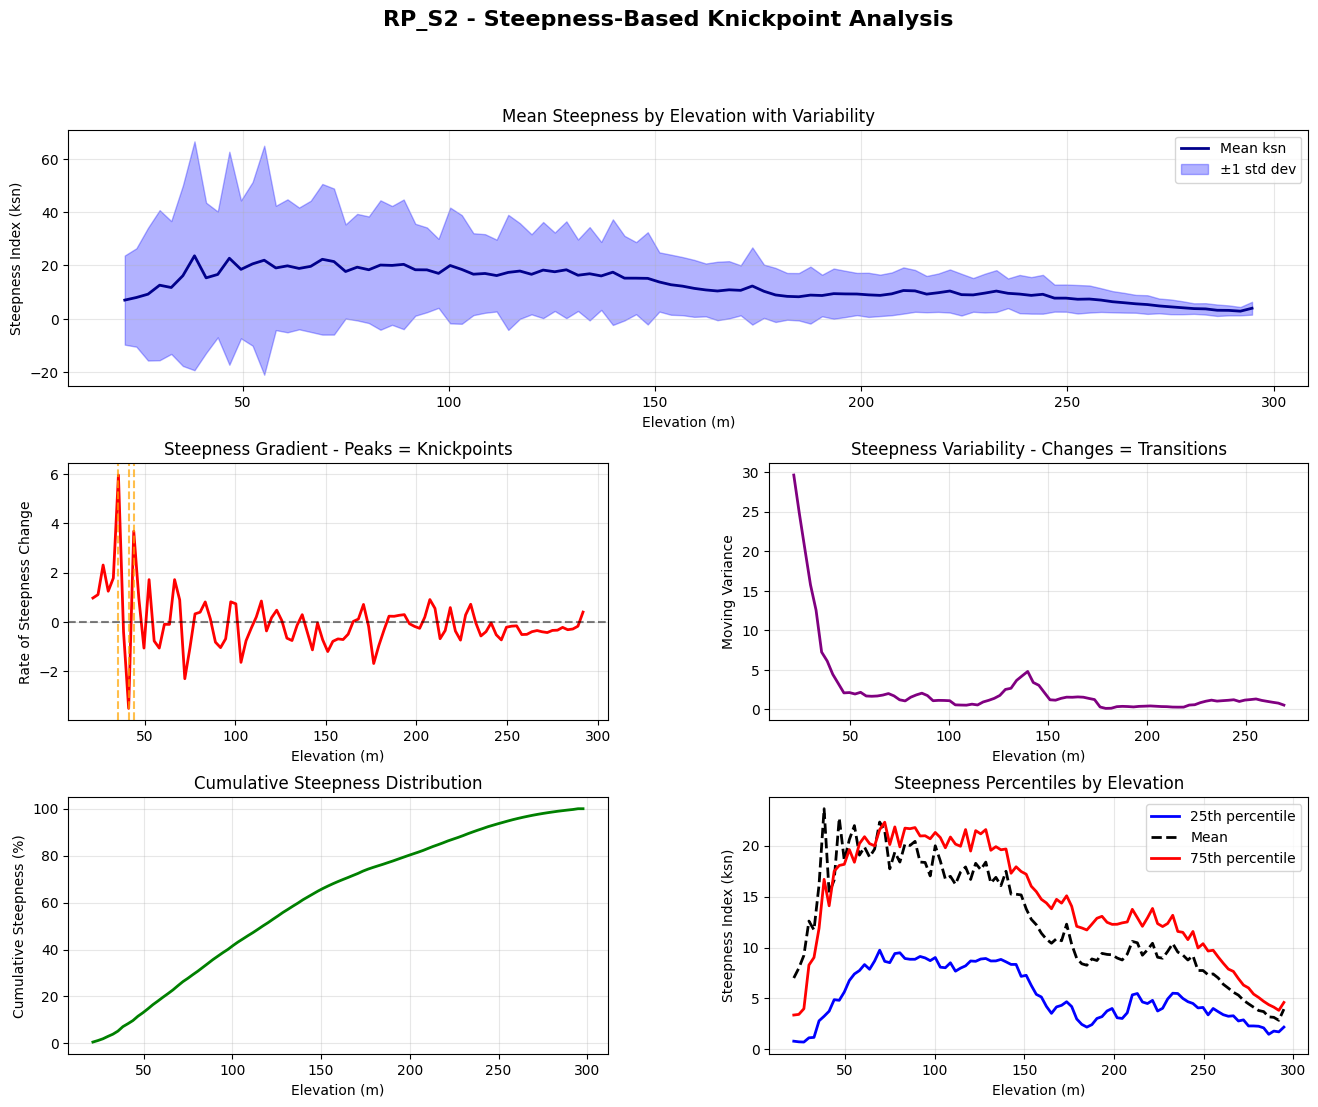


=== RP_S2 KNICKPOINT CANDIDATES (Steepness) ===
1. Elevation: 36m | Change: 5.952 ksn/m | Direction: flat→steep
2. Elevation: 44m | Change: 3.678 ksn/m | Direction: flat→steep
3. Elevation: 41m | Change: -3.497 ksn/m | Direction: steep→flat
4. Elevation: 27m | Change: 2.309 ksn/m | Direction: flat→steep
5. Elevation: 72m | Change: -2.295 ksn/m | Direction: steep→flat

Elevation range: 20m to 299m
Mean steepness: 12.77
Median steepness: 9.09
Max steepness: 484.99
Processing RP_S3...


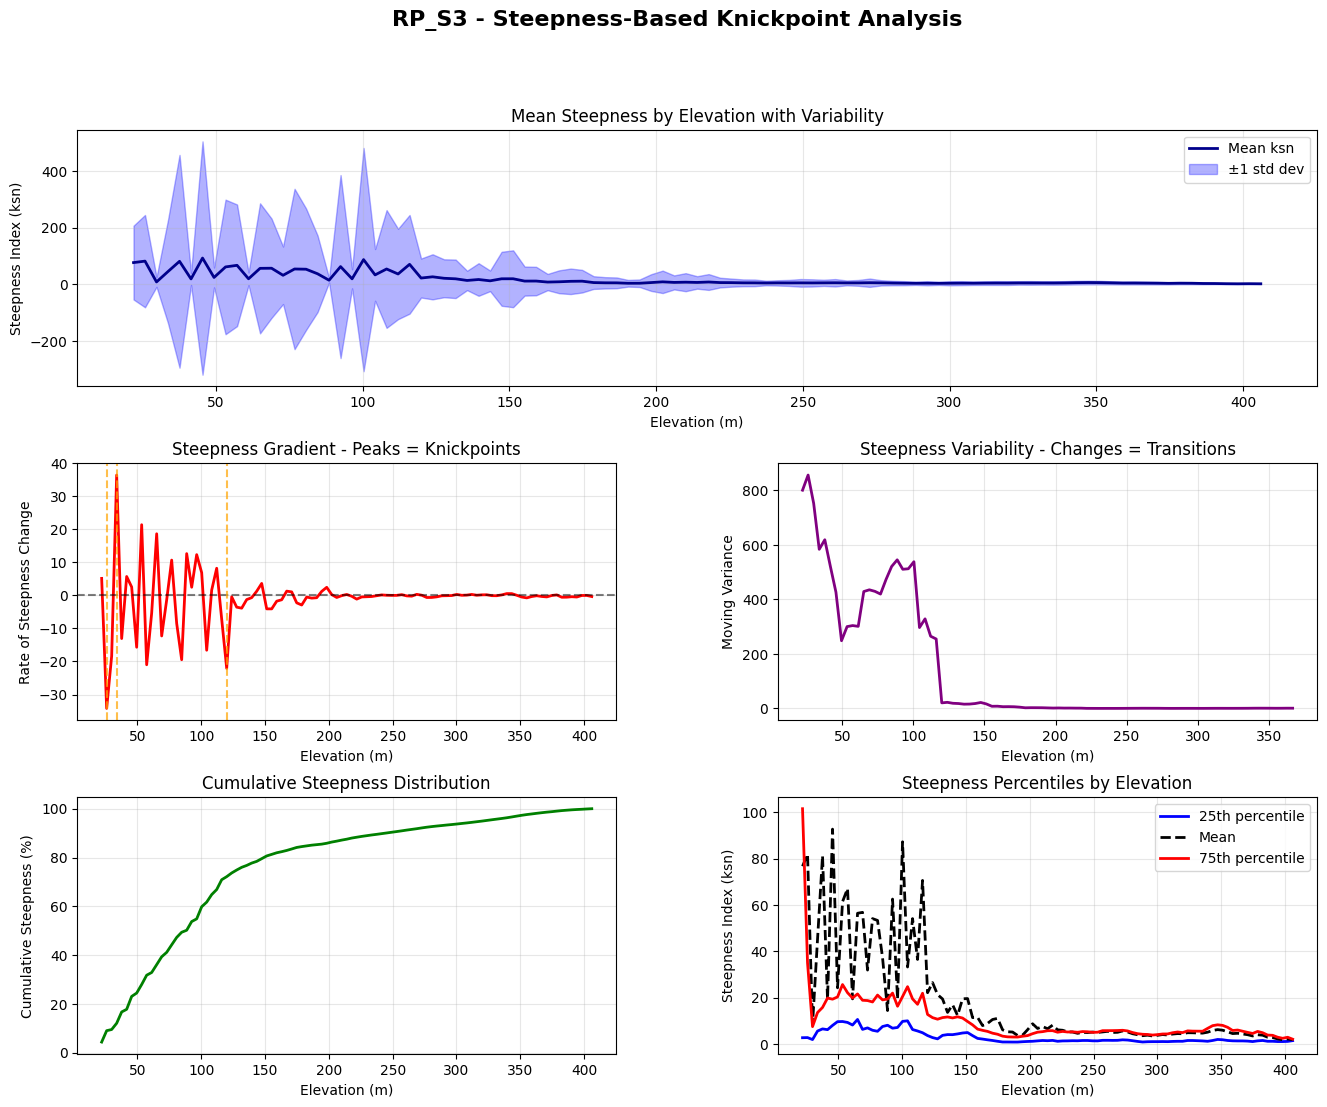


=== RP_S3 KNICKPOINT CANDIDATES (Steepness) ===
1. Elevation: 34m | Change: 36.476 ksn/m | Direction: flat→steep
2. Elevation: 26m | Change: -34.203 ksn/m | Direction: steep→flat
3. Elevation: 120m | Change: -22.069 ksn/m | Direction: steep→flat
4. Elevation: 53m | Change: 21.433 ksn/m | Direction: flat→steep
5. Elevation: 57m | Change: -20.986 ksn/m | Direction: steep→flat

Elevation range: 20m to 408m
Mean steepness: 5.29
Median steepness: 2.50
Max steepness: 2450.03
Processing RP_S3u...


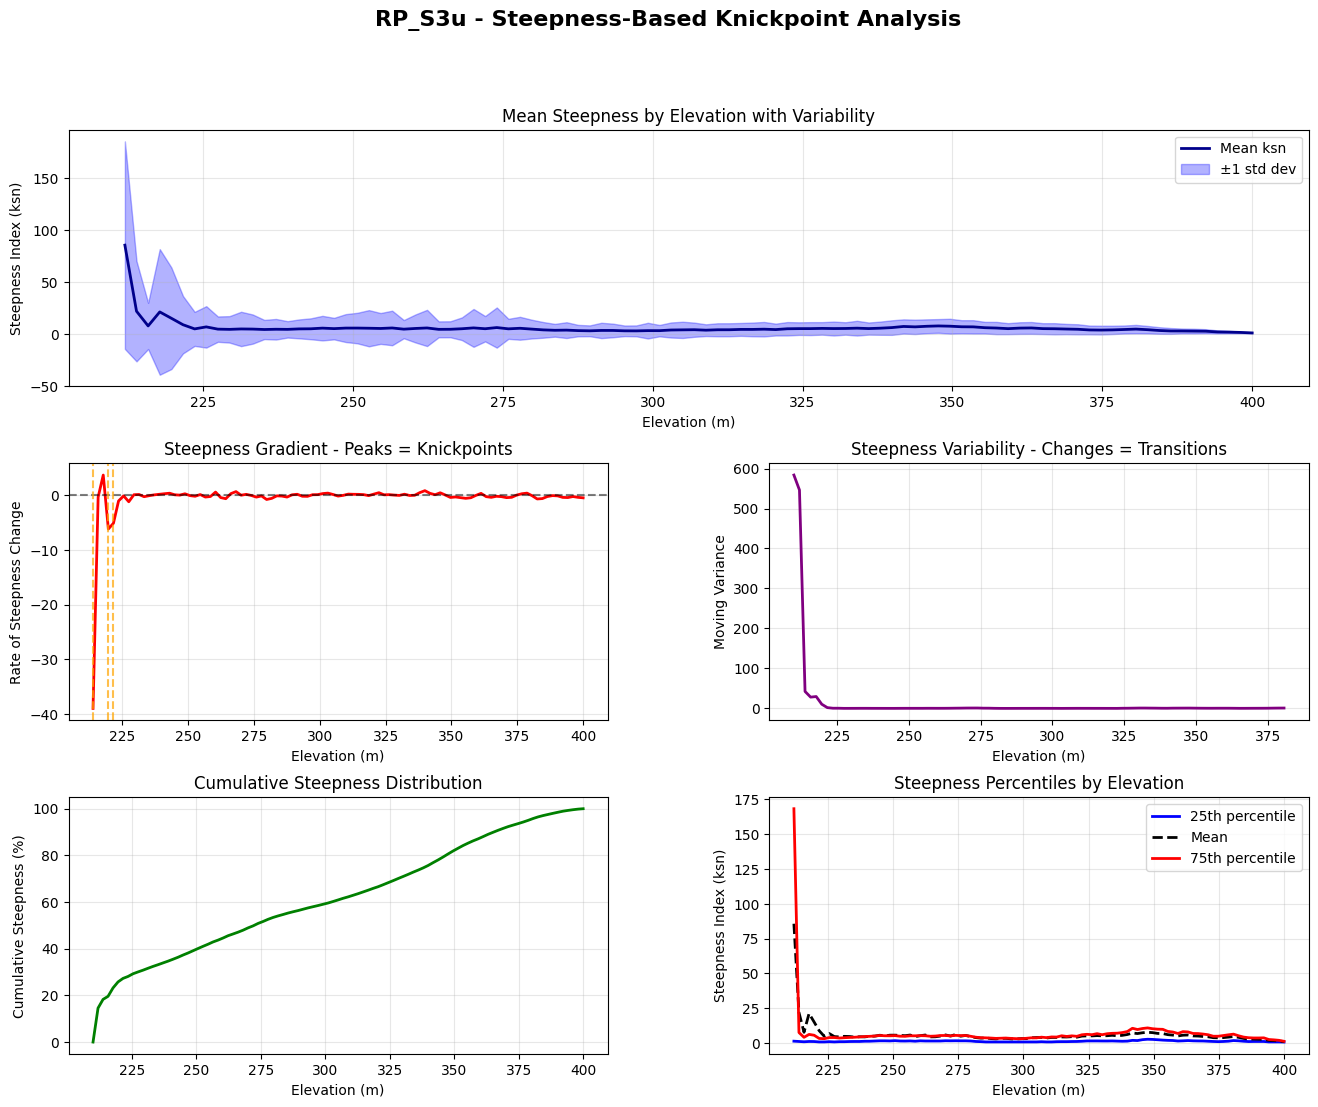


=== RP_S3u KNICKPOINT CANDIDATES (Steepness) ===
1. Elevation: 214m | Change: -38.966 ksn/m | Direction: steep→flat
2. Elevation: 220m | Change: -6.173 ksn/m | Direction: steep→flat
3. Elevation: 222m | Change: -5.119 ksn/m | Direction: steep→flat
4. Elevation: 218m | Change: 3.688 ksn/m | Direction: flat→steep
5. Elevation: 227m | Change: -1.194 ksn/m | Direction: steep→flat

Elevation range: 209m to 401m
Mean steepness: 4.70
Median steepness: 2.41
Max steepness: 542.11
Processing RP_S4u...


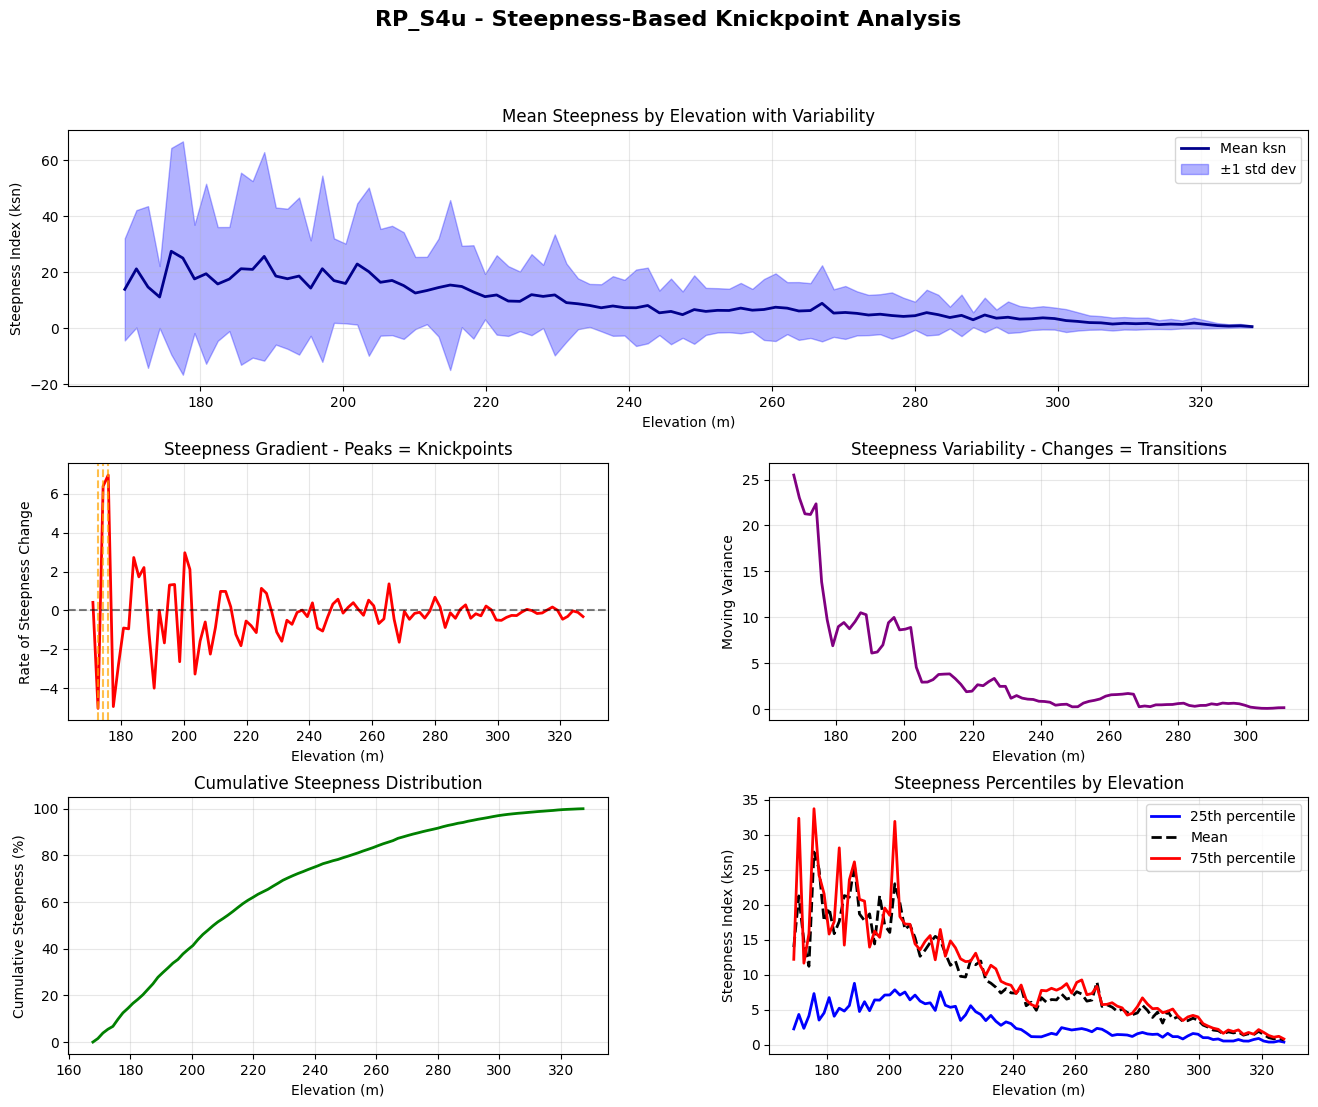


=== RP_S4u KNICKPOINT CANDIDATES (Steepness) ===
1. Elevation: 176m | Change: 6.954 ksn/m | Direction: flat→steep
2. Elevation: 174m | Change: 6.377 ksn/m | Direction: flat→steep
3. Elevation: 173m | Change: -5.029 ksn/m | Direction: steep→flat
4. Elevation: 178m | Change: -4.936 ksn/m | Direction: steep→flat
5. Elevation: 191m | Change: -3.991 ksn/m | Direction: steep→flat

Elevation range: 167m to 328m
Mean steepness: 6.57
Median steepness: 3.17
Max steepness: 224.19


In [21]:
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt

def steepness_knickpoint_analysis(shapefile_path, dem_path, area_path, title):
    """Comprehensive knickpoint analysis using steepness index (ksn)"""
    
    # Read shapefile
    shapefile = gpd.read_file(shapefile_path)
    
    # Clip DEM to shapefile
    print(f"Processing {title}...")
    with rasterio.open(dem_path) as dem_src:
        elevation, transform = mask(dem_src, shapefile.geometry, crop=True)
        elevation = elevation[0]
        nodata = dem_src.nodata
    
    # Clip drainage area to shapefile
    with rasterio.open(area_path) as area_src:
        drainage_area, _ = mask(area_src, shapefile.geometry, crop=True)
        drainage_area = drainage_area[0]
    
    # Clean elevation data
    elevation = elevation.astype(np.float32)
    if nodata is not None:
        elevation[elevation == nodata] = np.nan
    elevation[elevation == -32768] = np.nan
    
    # Calculate slope
    cell_size = transform[0]
    dy, dx = np.gradient(elevation, cell_size)
    slope_ratio = np.sqrt(dx**2 + dy**2)
    
    # Calculate steepness index (ksn)
    theta = 0.45
    steepness = slope_ratio * (drainage_area ** theta)
    
    # Filter valid values
    valid_mask = (~np.isnan(steepness) & 
                  ~np.isnan(elevation) & 
                  (elevation > 0) & 
                  (elevation < 10000) &
                  (drainage_area > 0))
    
    steepness_valid = steepness[valid_mask]
    elevation_valid = elevation[valid_mask]
    
    # Statistical analysis by elevation
    elevation_bins = np.linspace(elevation_valid.min(), elevation_valid.max(), 100)
    bin_centers = (elevation_bins[:-1] + elevation_bins[1:]) / 2
    mean_steepness = []
    std_steepness = []
    p25_steepness = []
    p75_steepness = []
    
    for i in range(len(elevation_bins) - 1):
        mask_bin = (elevation_valid >= elevation_bins[i]) & (elevation_valid < elevation_bins[i+1])
        if np.sum(mask_bin) > 10:
            mean_steepness.append(np.mean(steepness_valid[mask_bin]))
            std_steepness.append(np.std(steepness_valid[mask_bin]))
            p25_steepness.append(np.percentile(steepness_valid[mask_bin], 25))
            p75_steepness.append(np.percentile(steepness_valid[mask_bin], 75))
        else:
            mean_steepness.append(np.nan)
            std_steepness.append(np.nan)
            p25_steepness.append(np.nan)
            p75_steepness.append(np.nan)
    
    mean_steepness = np.array(mean_steepness)
    std_steepness = np.array(std_steepness)
    
    # Calculate rate of change (gradient of steepness with elevation)
    steepness_change = np.gradient(mean_steepness)
    
    # Moving window variance
    window_size = 10
    moving_variance = []
    for i in range(len(mean_steepness) - window_size):
        moving_variance.append(np.nanvar(mean_steepness[i:i+window_size]))
    
    # Create plots
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Mean steepness with confidence bands
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(bin_centers, mean_steepness, linewidth=2, color='darkblue', label='Mean ksn')
    ax1.fill_between(bin_centers, 
                      mean_steepness - std_steepness, 
                      mean_steepness + std_steepness, 
                      alpha=0.3, color='blue', label='±1 std dev')
    ax1.set_xlabel('Elevation (m)')
    ax1.set_ylabel('Steepness Index (ksn)')
    ax1.set_title('Mean Steepness by Elevation with Variability')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Rate of change
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(bin_centers, steepness_change, linewidth=2, color='red')
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Elevation (m)')
    ax2.set_ylabel('Rate of Steepness Change')
    ax2.set_title('Steepness Gradient - Peaks = Knickpoints')
    ax2.grid(True, alpha=0.3)
    
    # Mark top 3 candidates
    valid_indices = ~np.isnan(steepness_change)
    if np.sum(valid_indices) > 0:
        abs_changes = np.abs(steepness_change[valid_indices])
        top_3_indices = np.argsort(abs_changes)[-3:]
        valid_bin_centers = bin_centers[valid_indices]
        for idx in top_3_indices:
            ax2.axvline(valid_bin_centers[idx], color='orange', linestyle='--', alpha=0.7)
    
    # Plot 3: Moving variance
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(bin_centers[:len(moving_variance)], moving_variance, linewidth=2, color='purple')
    ax3.set_xlabel('Elevation (m)')
    ax3.set_ylabel('Moving Variance')
    ax3.set_title('Steepness Variability - Changes = Transitions')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Cumulative distribution
    ax4 = fig.add_subplot(gs[2, 0])
    cumsum_steepness = np.nancumsum(mean_steepness)
    cumsum_steepness = cumsum_steepness / cumsum_steepness[-1] * 100
    ax4.plot(bin_centers, cumsum_steepness, linewidth=2, color='green')
    ax4.set_xlabel('Elevation (m)')
    ax4.set_ylabel('Cumulative Steepness (%)')
    ax4.set_title('Cumulative Steepness Distribution')
    ax4.grid(True, alpha=0.3)
    
    # Plot 5: Percentile analysis
    ax5 = fig.add_subplot(gs[2, 1])
    ax5.plot(bin_centers, p25_steepness, linewidth=2, color='blue', label='25th percentile')
    ax5.plot(bin_centers, mean_steepness, linewidth=2, color='black', label='Mean', linestyle='--')
    ax5.plot(bin_centers, p75_steepness, linewidth=2, color='red', label='75th percentile')
    ax5.set_xlabel('Elevation (m)')
    ax5.set_ylabel('Steepness Index (ksn)')
    ax5.set_title('Steepness Percentiles by Elevation')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    plt.suptitle(f'{title} - Steepness-Based Knickpoint Analysis', fontsize=16, fontweight='bold')
    plt.show()
    
    # Print statistics
    print(f"\n{'='*50}")
    print(f"=== {title} KNICKPOINT CANDIDATES (Steepness) ===")
    print(f"{'='*50}")
    
    valid_indices = ~np.isnan(steepness_change)
    if np.sum(valid_indices) > 0:
        abs_changes = np.abs(steepness_change[valid_indices])
        top_5_indices = np.argsort(abs_changes)[-5:][::-1]
        valid_bin_centers = bin_centers[valid_indices]
        valid_steepness_change = steepness_change[valid_indices]
        
        for i, idx in enumerate(top_5_indices, 1):
            elev = valid_bin_centers[idx]
            change = valid_steepness_change[idx]
            direction = "steep→flat" if change < 0 else "flat→steep"
            print(f"{i}. Elevation: {elev:.0f}m | Change: {change:.3f} ksn/m | Direction: {direction}")
    
    print(f"\nElevation range: {elevation_valid.min():.0f}m to {elevation_valid.max():.0f}m")
    print(f"Mean steepness: {np.mean(steepness_valid):.2f}")
    print(f"Median steepness: {np.median(steepness_valid):.2f}")
    print(f"Max steepness: {np.max(steepness_valid):.2f}")


# File paths
dem_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_SRTMGL130m_dem_utm.tif'
area_path = '/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver/rapel_area_utm30m'

# Run analysis for all 4 shapefiles
steepness_knickpoint_analysis(
    '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S2_mask/RP_S2_mask.shp', 
    dem_path, area_path, 'RP_S2')

steepness_knickpoint_analysis(
    '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3_mask/RP_S3_mask.shp', 
    dem_path, area_path, 'RP_S3')

steepness_knickpoint_analysis(
    '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S3u_mask/RP_S3u_mask.shp', 
    dem_path, area_path, 'RP_S3u')

steepness_knickpoint_analysis(
    '/Users/Glong1/Desktop/Andes/AndesTG/Rapel/output_polygons/RP_S4u_mask/RP_S4u_mask.shp', 
    dem_path, area_path, 'RP_S4u')